In [1]:
from google.colab import files
uploaded = files.upload()


Saving merged_gw_2324.csv to merged_gw_2324.csv


In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.colors as mcolors
# Replace 'filename.csv' with the actual name of your file
df = pd.read_csv('merged_gw_2324.csv')

df['value'] = df['value'] /10
columns_to_exclude_ML = ['xP','bonus','bps','element','creativity','fixture','influence',
                         'kickoff_time','opponent_team','round','team_a_score', 'team_h_score',
                         'threat','transfers_balance', 'transfers_in','transfers_out',
                          'was_home','yellow_cards','red_cards','penalties_missed','goals_conceded','GW',
                          'goals_scored', 'assists', 'clean_sheets', 'minutes', 'saves', 'yellow_cards',
                    'red_cards', 'penalties_missed', 'penalties_saved', 'own_goals', 'bonus']
# Drop the specified columns
df_filtered = df.drop(columns=columns_to_exclude_ML)

# Print the resulting DataFrame
df_filtered.head()


name position           team  expected_assists  \
0             Femi Seriki      DEF  Sheffield Utd              0.00   
1        Jack Hinshelwood      MID       Brighton              0.00   
2            Jadon Sancho      MID        Man Utd              0.05   
3  Rhys Norrington-Davies      DEF  Sheffield Utd              0.00   
4           Vitaly Janelt      MID      Brentford              0.01   

   expected_goal_involvements  expected_goals  expected_goals_conceded  \
0                        0.00            0.00                     0.00   
1                        0.00            0.00                     0.00   
2                        0.05            0.00                     1.08   
3                        0.00            0.00                     0.00   
4                        0.03            0.02                     1.26   

   ict_index  selected  starts  total_points  value  
0        0.0         0       0             0    4.0  
1        0.0       822       0             0    4.5  
2        2.3     83993       0             1    7.0  
3        0.0      6456       0             0    4.0  
4        4.3      6508       1             2    5.5

#Showing correlation

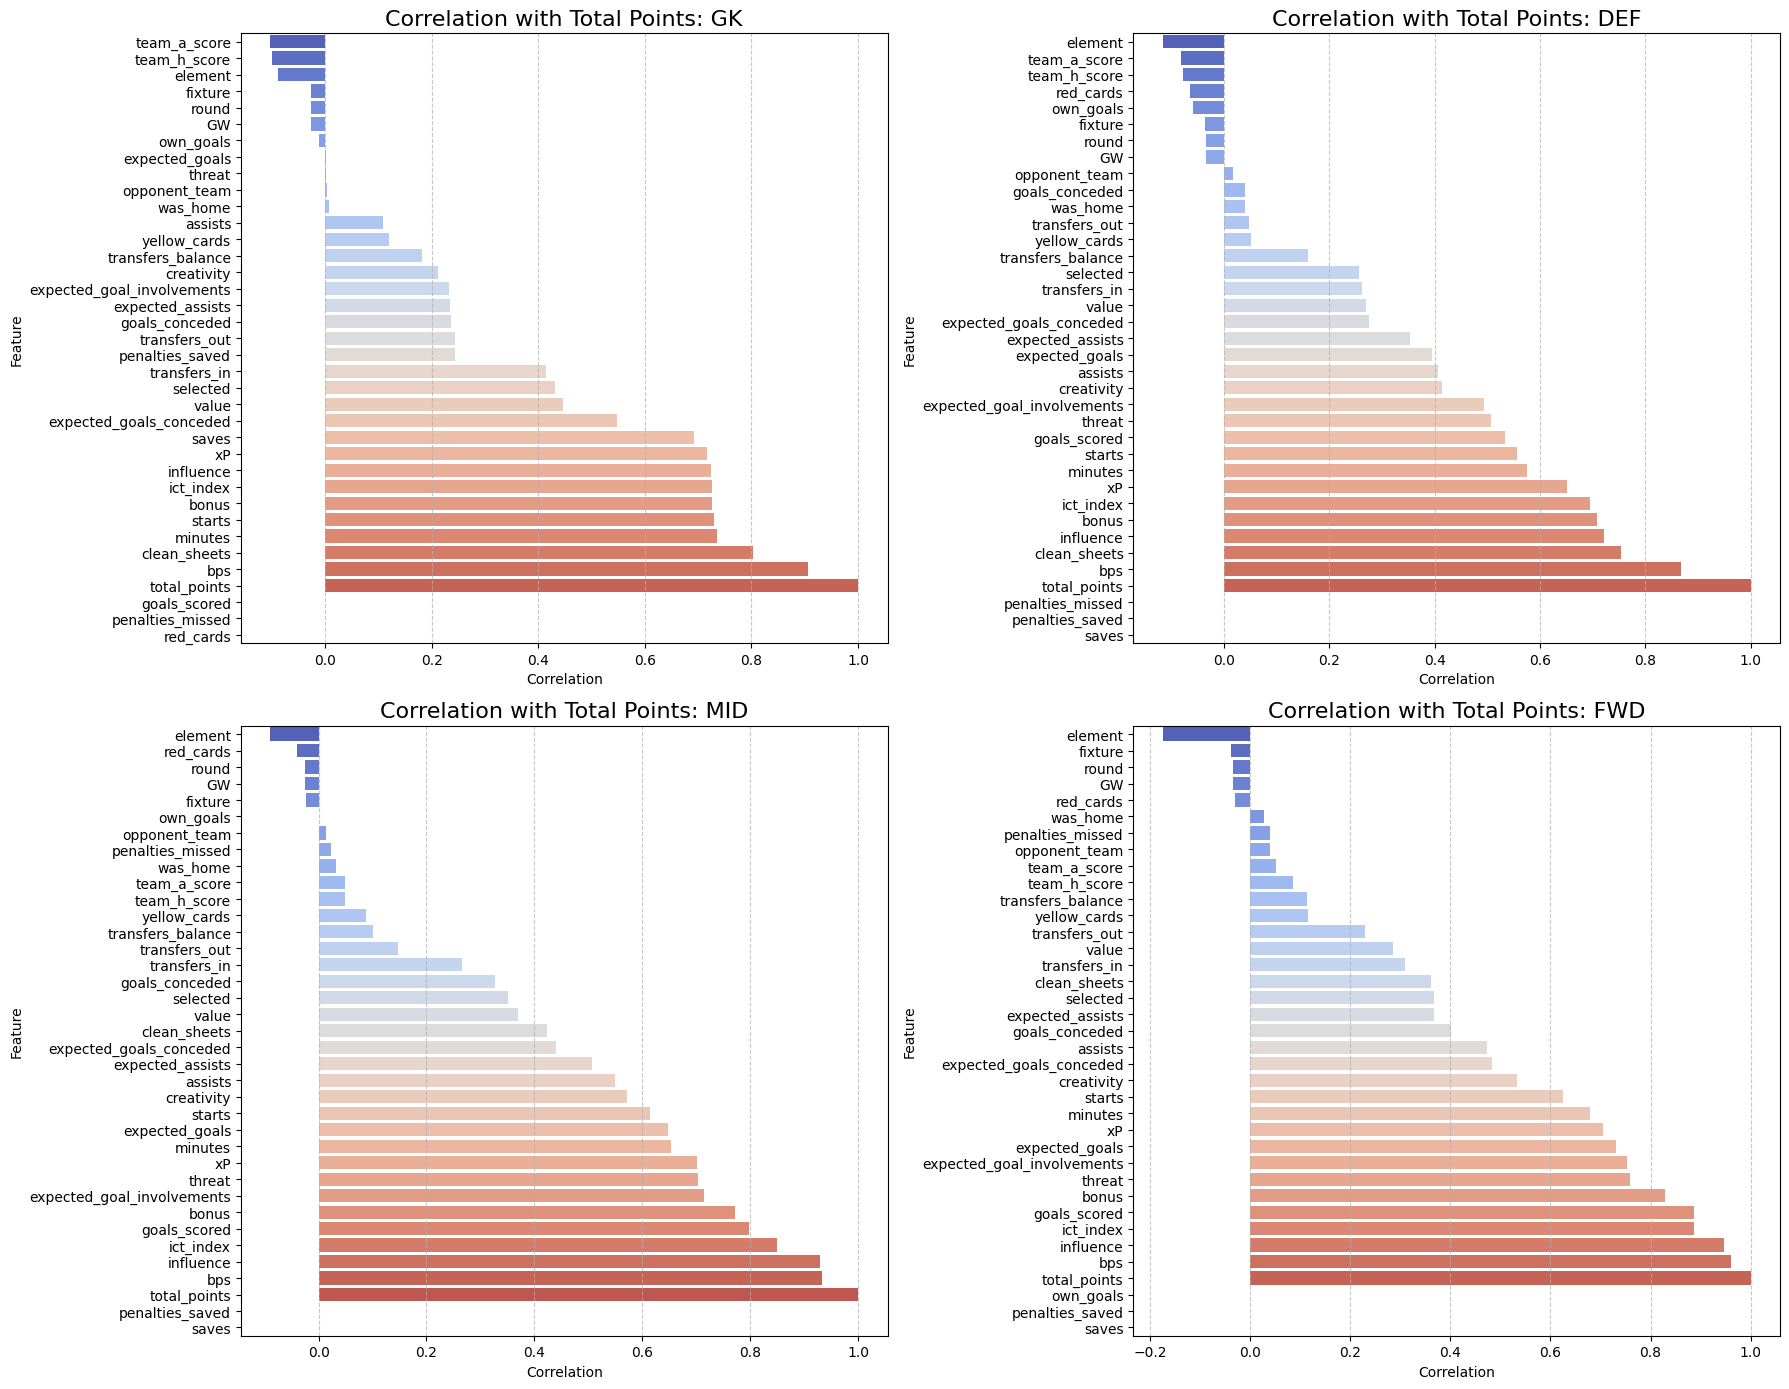

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Define player positions
positions = ['GK', 'DEF', 'MID', 'FWD']

# Set up the plot area
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Loop through each position group
for i, pos in enumerate(positions):
    # Filter for position
    df_pos = df[df['position'] == pos] # all dataset
    # df_pos = df_filtered[df_filtered['position'] == pos]filtered dataset

    # Compute correlation with total_points
    corr = df_pos.corr(numeric_only=True)['total_points'].sort_values(ascending=True)

    # Plot
    sns.barplot(x=corr.values, y=corr.index, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Correlation with Total Points: {pos}', fontsize=16)
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Feature')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")

plt.show()

#Traditional Approach only with expected total_points

In [4]:
columns_to_keep = ['name','position','team','value','total_points']
columns_to_keep_test = ['name','position','team','value','total_points','GW']
simple_df = df[columns_to_keep]
simple_df.head()

name position           team  value  total_points
0             Femi Seriki      DEF  Sheffield Utd    4.0             0
1        Jack Hinshelwood      MID       Brighton    4.5             0
2            Jadon Sancho      MID        Man Utd    7.0             1
3  Rhys Norrington-Davies      DEF  Sheffield Utd    4.0             0
4           Vitaly Janelt      MID      Brentford    5.5             2

In [5]:
# Suppress specific warnings from statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore", category=Warning, module="statsmodels")

# Spliting data
gameweek = 27 #gameweek 27
for index, row in df.iterrows():
  if row['GW'] == gameweek:
    idx = index
    break
# train,test = simple_df[:idx],df[columns_to_keep_test][idx:] #traditional method
train,test = df_filtered[:idx],df[idx:] #traditional method

##averaging function

In [6]:
import numpy as np
import math
from scipy.stats import poisson

def average(points, method, arima_order=(0, 0, 1)):
  #simple average
  if method == 'simple':
    return points.mean()
  elif method == 'weighted':
    # Generate weights: most recent row gets the highest weight
    weights = np.arange(1, len(points) + 1)  # 1 to N (older to newer)
    weights = weights / weights.sum()  # normalize weights to sum to 1
    return (points.multiply(weights, axis=0)).sum()
  elif method == 'simulation-non parametric':
    num_simulations=1000
    np.random.seed(54) #99=569
    return np.random.choice(points, size=num_simulations, replace=True).mean()
  elif method == 'monte carlo':
    num_simulations=1000 #previous 10000

    mean_score = np.mean(points)
    std_score = np.std(points, ddof=1)  # unbiased estimator
    if math.isnan(mean_score) or math.isnan(std_score):
      return 0
    np.random.seed(123) #123=545
    return np.random.normal(mean_score, std_score, num_simulations).mean()
  elif method == 'arima':
    # print(arima_order)
    if len(points) < 2 or points.mean()==0:
      return points.mean()  # Fall back to mean (or last value)
    try:
        model = ARIMA(points, order=arima_order) #best = 001
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=38 - gameweek)

        return predictions.mean()  # or whatever you want to do with the forecast
    except Exception as e:
          print("ARIMA failed:", e)
          return points.mean()

  elif method == 'linear regression':
    if len(points) < 2 or points.mean()==0:
        return points.mean()  # Fall back to mean (or last value)
    try:
      # Create weeks array matching the length of points
      weeks = np.arange(1, len(points) + 1).reshape(-1, 1)
      scores = np.array(points)
      # Fit the model
      reg = LinearRegression()
      reg.fit(weeks, scores)

      # Predict from next week up to GW38
      future_weeks = np.arange(len(points) + 1, 39).reshape(-1, 1)
      predictions = reg.predict(future_weeks)
      return predictions.mean()
    except Exception as e:
      print("linear regression failed:", e)
      return points.mean()
  elif method == 'cvar':
    return points.to_numpy()
  elif method == 'exponential smoothing':
    if len(points) < 2:
      return points.mean()  # Fall back to mean (or last value)
    model = ExponentialSmoothing(points, trend='add')
    fit = model.fit()
    predictions = fit.forecast(38-gameweek)
    return predictions.mean()
  else:
    raise ValueError(f"Unknown method: {method}")

#Handling time series, using only expected points

In [7]:
#handle time series data
names = train['name'].unique()
import math
def calling_average(train, method, arima_order = (0,0,1)):
  names = train['name'].unique()
  scores = []
  count = 0
  method__ = method
  for name in names:
    count+=1
    points = train[train['name'] == name]['total_points']
    last_value = train[train['name'] == name]['value'].iloc[-1]
    average_ = average(points,method=method__, arima_order = arima_order) #prediction method
    sd = points.std()
    if math.isnan(sd):
      sd = 500
    position = train[train['name'] == name]['position'].iloc[-1]
    team = train[train['name'] == name]['team'].iloc[-1]
    scores.append({
          'name': name,
          'team': team,
          'position': position,
          'expected points': average_,
          'uncertainty': sd,
          'value': last_value
      })
  return pd.DataFrame(scores)


#Handling time series for all features that are not included in the expected total_points


In [8]:
#handling time series for hybrid
import math
def hybrid_average(points, method):
  if method == 'simple average':
    return points.mean()
  elif method == 'linear regression':
      forecasts = {}
      numeric_cols = points.select_dtypes(include='number').columns

      for col in numeric_cols:
          col_data = points[col]
          if len(col_data) < 2 or col_data.mean() == 0:
              forecasts[col] = col_data.mean()  # fallback to mean
          else:
              try:
                  # Create weeks array matching the length of points
                  weeks = np.arange(1, len(col_data) + 1).reshape(-1, 1)
                  scores = col_data.values.reshape(-1, 1)
                  reg = LinearRegression()
                  reg.fit(weeks, scores)

                  # Predict from next week up to GW38
                  future_weeks = np.arange(len(col_data) + 1, 39).reshape(-1, 1)
                  predictions = reg.predict(future_weeks)
                  forecasts[col] = predictions.mean()
              except Exception as e:
                  print(f"Linear regression failed for {col}: {e}")
                  forecasts[col] = col_data.mean()  # fallback if regression fails

      return pd.Series(forecasts)
  if method == 'simple ICT':
        # Return a Series with 'ict_index' and mean for other numeric columns
        forecasts = {}
        forecasts['ict_index'] = points['ict_index'].mean()
        for col in points.select_dtypes(include='number').columns:
            if col != 'ict_index':
                forecasts[col] = points[col].mean()
        return pd.Series(forecasts)
  elif method == 'exponential smoothing':
    forecasts = {}
    numeric_cols = points.select_dtypes(include='number').columns

    for col in numeric_cols:
        col_data = points[col].dropna()
        if len(col_data) < 2:
            forecasts[col] = col_data.mean()
            continue
        try:
            model = ExponentialSmoothing(col_data, trend='add', initialization_method="estimated")
            fit = model.fit()
            steps = max(1, 38 - gameweek)  # safeguard against negative/zero
            predictions = fit.forecast(steps)
            forecasts[col] = predictions.mean()
        except Exception as e:
            print(f"Exponential smoothing failed for {col}: {e}")
            forecasts[col] = col_data.mean()

    return pd.Series(forecasts)
  elif method == 'simulation-non parametric':
    num_simulations = 1000
    forecasts = {}
    numeric_cols = points.select_dtypes(include='number').columns

    for col in numeric_cols:
        col_data = points[col].dropna()
        if len(col_data) == 0:
            forecasts[col] = 0
            continue
        try:
            np.random.seed(54)  # reproducibility
            simulated_values = np.random.choice(col_data, size=num_simulations, replace=True)
            forecasts[col] = simulated_values.mean()
        except Exception as e:
            print(f"Non-parametric simulation failed for {col}: {e}")
            forecasts[col] = col_data.mean()

    return pd.Series(forecasts)

  elif method == 'monte carlo':
      num_simulations = 1000  # previous 10000
      forecasts = {}
      numeric_cols = points.select_dtypes(include='number').columns

      for col in numeric_cols:
          col_data = points[col].dropna()
          mean_score = np.mean(col_data)
          std_score = np.std(col_data, ddof=1)  # unbiased estimator

          if math.isnan(mean_score) or math.isnan(std_score) or len(col_data) < 2:
              forecasts[col] = mean_score if not math.isnan(mean_score) else 0
          else:
              try:
                  np.random.seed(123)  # reproducibility
                  simulated = np.random.normal(mean_score, std_score, num_simulations)
                  forecasts[col] = simulated.mean()
              except Exception as e:
                  print(f"Monte Carlo failed for {col}: {e}")
                  forecasts[col] = mean_score

      return pd.Series(forecasts)
  if method == 'arima':
        # Only forecast 'total_points' with ARIMA
        forecasts = {}
        if len(points['total_points']) < 2 or points['total_points'].mean() == 0:
            # Fall back to mean for all numeric columns
            return points.mean()
        try:
            model = ARIMA(points['total_points'], order=(0,0,1))  # best = 011
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=38 - gameweek)
            # Return as Series with 'total_points' and all other numeric columns
            forecasts['total_points'] = predictions.mean()
            for col in points.select_dtypes(include='number').columns:
                if col != 'total_points':
                    forecasts[col] = points[col].mean()  # fallback to mean for other columns
            return pd.Series(forecasts)
        except Exception as e:
            print("ARIMA failed:", e)
            # Return mean for all numeric columns if ARIMA fails
            return points.mean()
  elif method == 'weighted':
    # Create weights that increase over time (more recent = higher weight)
    weights = np.arange(1, len(points) + 1)

    # Apply weighted average for each column
    weighted_avg = (points.multiply(weights, axis=0)).sum() / weights.sum()

    return weighted_avg
def calling_hybrid_average(train, method):
  names = train['name'].unique()
  scores = []
  for name in names:
    points = train[train['name'] == name]
    last_value = train[train['name'] == name]['value'].iloc[-1]
    average_ = hybrid_average(points.select_dtypes(include='number'),method=method) #prediction method
    sd_ICT   = points['ict_index'].std()
    if math.isnan(sd_ICT):
      sd_ICT = 500
    position = train[train['name'] == name]['position'].iloc[-1]
    team = train[train['name'] == name]['team'].iloc[-1]
    scores.append({
          'name': name,
          'team': team,
          'position': position,
          "ICT_uncertainty":sd_ICT,
          'value': last_value
      })
    scores_temp = {}
    for item in average_.keys():
      if item != 'value':
        scores_temp[item] = average_[item]
    scores[-1].update(scores_temp)

  return pd.DataFrame(scores)


#create column for hidden total points- Using linear regression to find the relationship between unused features with total_points

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge  # instead of LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
def hybrid_weighting(scores_df_,a,b):
  # We'll create a new column for hybrid points
  scores_df_['hybrid_points'] = 0.0

  # Define the target and feature columns (only numeric and useful ones)
  feature_cols = [
      'expected_assists', 'expected_goal_involvements', 'expected_goals',
      'expected_goals_conceded', 'ict_index', 'selected', 'starts',
      'total_points'  # include total_points for now, we'll drop it when modeling
  ]

  # Process for each position
  for position in scores_df_['position'].unique():
      df_pos = scores_df_[scores_df_['position'] == position].copy()

      # Drop rows with NaNs
      df_pos = df_pos.dropna(subset=feature_cols)

      # Define X and y
      X = df_pos[feature_cols].drop(columns=['total_points'])
      y = df_pos['total_points']

      # Normalize features to prevent large coefficients
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(X)

      # Fit Ridge regression (L2 regularization)
      # model = LinearRegression(fit_intercept=False)
      model = Ridge(alpha=1.0, fit_intercept=False)  # alpha controls strength of regularization (higher = more regularization)
      model.fit(X_scaled, y)

      # Get predictions and scale them
      y_pred = model.predict(X)
      # Normalize predictions to [0, 1] range for fair combination
      y_pred_normalized = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())

      # # Get total_points also scaled to [0, 1]
      total_points_scaled = (y - y.min()) / (y.max() - y.min())

      # Combine with 2:1 ratio (total_points has double weight)
      hybrid = (a * total_points_scaled + b * y_pred_normalized) / 3 #a=2 b= 1
      # hybrid = (1 * y + 2 * y_pred) / 3 # with no intercept
      # Map back to the scores_df by index
      scores_df_.loc[df_pos.index, 'hybrid_points'] = hybrid * y.max()  # scale back to similar magnitude
  return scores_df_

#Optimizing

In [10]:
!apt-get install -y glpk-utils
# !apt-get install -y coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 38 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [11]:
import pyomo.environ as pyo
import pandas as pd
from collections import defaultdict

def starting_eleven(scores_df, obj, scores_df_=None, budget = 83.5):
  print('starting eleven: \n')
  # Mapping position to indices (optional, for display only)
  position_map = {"GK": 0, "DEF": 1, "MID": 2, "FWD": 3}

  # Group players by team
  teams = scores_df["team"].unique()
  team_players = defaultdict(list)

  for idx, row in scores_df.iterrows():
      team_players[row["team"]].append(idx)  # Use DataFrame index for player IDs

  # Model setup
  model = pyo.ConcreteModel()
  n_players = len(names)

  budget = budget #83.5
  num_players = 11

  # Decision variable: Binary (1 if player j is selected, 0 otherwise)
  model.x = pyo.Var(range(n_players), domain=pyo.Binary) #players
  model.y = pyo.Var(range(n_players), domain=pyo.Binary) #1 if capitan is player j

  # Objective function: Maximize total score
  def Obj(model):
    if obj == 'expected':
      return sum(scores_df.loc[j, "expected points"] * model.x[j]
      for j in range(n_players)) + sum(scores_df.loc[j, "expected points"] * model.y[j] for j in range(n_players))  #regular objective function only expected points
    if obj == 'hybrid':
      return sum(scores_df_.loc[j, "hybrid_points"] * model.x[j]
      for j in range(n_players)) + sum(scores_df_.loc[j, "hybrid_points"] * model.y[j] for j in range(n_players))   #using hybrid points
    if obj == 'ICT':

      return sum(scores_df_.loc[j, "ict_index"] * model.x[j]
      for j in range(n_players)) + sum(scores_df_.loc[j, "ict_index"] * model.y[j] for j in range(n_players))   #maximum expected ICT points

    if obj == 'involvement':
      return sum(scores_df_.loc[j, "expected_goal_involvements"] * model.x[j]
      for j in range(n_players)) + sum(scores_df_.loc[j, "expected_goal_involvements"] * model.y[j] for j in range(n_players)) - (sum
      (scores_df_.loc[j, "expected_goals_conceded"] * model.x[j]
      for j in range(n_players)) + sum(scores_df_.loc[j, "expected_goals_conceded"] * model.y[j] for j in range(n_players)) )
    if obj == 'robust expected':
        return sum(
          (scores_df.loc[j, "expected points"] - scores_df.loc[j, "uncertainty"])
          * (model.x[j] + model.y[j])
          for j in range(n_players)
      )
    if obj == 'robust ICT':
        return sum(
          (scores_df_.loc[j, "ict_index"] - scores_df_.loc[j, "ICT_uncertainty"])
          * (model.x[j] + model.y[j])
          for j in range(n_players)
      )

      # return model.eta - (1/((1-alpha)*T)) * sum(model.z[t] for t in range(T))
  model.obj = pyo.Objective(rule=Obj, sense=pyo.maximize)

  #CVaR constraint
  # def z_constraints(model, t):
  #     return model.z[t] >= model.eta - sum(
  #         scores_df_.loc[j, "expected points"][t] * (model.x[j] + model.y[j])
  #         for j in range(n_players)
  #     )

  # model.z_constr = pyo.Constraint(range(T), rule=z_constraints)



  # robust optimization
  def RobustObj(model):
      return sum(
          (scores_df_.loc[j, "ict_index"] - scores_df_.loc[j, "ICT_uncertainty"])
          * (model.x[j] + model.y[j])
          for j in range(n_players)
      )
      # return sum(
      #     (scores_df.loc[j, "expected points"] - scores_df.loc[j, "uncertainty"])
      #     * (model.x[j] + model.y[j])
      #     for j in range(n_players)
      # )
  # model.obj = pyo.Objective(rule=RobustObj, sense=pyo.maximize)  # ← this must be present






  # Constraint 1: Exactly 11 players must be selected
  def Co1(model):
      return sum(model.x[j] for j in range(n_players)) == num_players
  model.Co1 = pyo.Constraint(rule=Co1)



  # Constraint 2: Budget ≤ 83.4
  def Co2(model):
      return sum(scores_df.loc[j, "value"] * model.x[j] for j in range(n_players)) <= budget
  model.Co2 = pyo.Constraint(rule=Co2)
  #constraint 3 #only select one capitan
  def Co3(model):
      return sum(model.y[j] for j in range(n_players)) == 1
  model.Co3 = pyo.Constraint(rule=Co3)
  #constraint 4:  #Capitan should be playing
  def Co4(model, j):
      return model.y[j] <= model.x[j]
  model.Co4 = pyo.Constraint(range(n_players), rule=Co4)


  # Constraint 5: Position-specific limits
  position_limits = {"GK": (1, 1), "DEF": (3, 5), "MID": (3, 5), "FWD": (1, 3)} #need to fill 2-5-5-3  = 15 players
  for position, (min_limit, max_limit) in position_limits.items():
      # Get indices of players in this position
      position_players = scores_df[scores_df["position"] == position].index.tolist()
      model.add_component(
          f"Min_{position}",
          pyo.Constraint(expr=sum(model.x[j] for j in position_players) >= min_limit)
      )
      model.add_component(
          f"Max_{position}",
          pyo.Constraint(expr=sum(model.x[j] for j in position_players) <= max_limit)
      )

  # Constraint 6: Maximum 3 players per team
  for team in teams:
      model.add_component(
          f"Max_Team_{team}",
          pyo.Constraint(expr=sum(model.x[j] for j in team_players[team]) <= 3)
      )
  # Solve the model
  solver = pyo.SolverFactory("glpk", executable="/usr/bin/glpsol")  # Ensure GLPK is installed

  solver.solve(model)

  # Display selected players
  selected_players = []
  capitan          = []
  for j in range(n_players):
      if pyo.value(model.x[j]) > 0.5:  # Player is selected
          selected_players.append(scores_df.loc[j, ["name", "team", "position",  "value"]]) #regular expected points-synced with the first objective function
          # selected_players.append(scores_df.loc[j, ["name", "team", "position", "ict_index", "value"]]) #regular expected points-synced with the first objective function

  for j in range(n_players):
      if pyo.value(model.y[j]) > 0.5:  # Player is selected
          capitan.append(scores_df.loc[j, ["name", "team", "position",  "value"]]) #regular expected points-synced with the first objective function
          # capitan.append(scores_df.loc[j, ["name", "team", "position", "ict_index", "value"]]) #regular expected points-synced with the first objective function

  # Convert to DataFrame for clean display
  # selected_df = pd.DataFrame(selected_players)
  print(pd.DataFrame(selected_players),'\n','capitan= ',pd.DataFrame(capitan))
  return pd.DataFrame(selected_players), capitan

#Optimizing Bench

In [12]:
# --- Bench Optimization Model ---

# Remaining budget
def bench(scores_df, selected_df, budget, n_players=len(names)):
  print('\n','--------------------------------------------', '\n','--------------------------------------------')
  teams = scores_df["team"].unique()
  bench_budget = 100 - budget

  # Count how many players per position are already in the starting XI
  num_starting = selected_df['position'].value_counts().to_dict()

  # How many per position we need on the bench
  bench_requirements = {
      "GK": 1,
      "DEF": 5 - num_starting.get("DEF", 0),
      "MID": 5 - num_starting.get("MID", 0),
      "FWD": 3 - num_starting.get("FWD", 0)
  }

  # New Pyomo model for bench
  bench_model = pyo.ConcreteModel()
  bench_model.xb = pyo.Var(range(n_players), domain=pyo.Binary)  # 1 if player selected for bench

  # Objective: maximize expected points
  def BenchObj(model):
      return sum(scores_df.loc[j, "expected points"] * model.xb[j] for j in range(n_players))
  bench_model.obj = pyo.Objective(rule=BenchObj, sense=pyo.maximize)

  # Constraint 1: Position-specific bench requirements
  for position, req in bench_requirements.items():
      position_players = scores_df[scores_df["position"] == position].index.tolist()
      bench_model.add_component(
          f"Bench_{position}",
          pyo.Constraint(expr=sum(bench_model.xb[j] for j in position_players) == req)
      )

  # Constraint 2: Budget limit for bench
  bench_model.budget_constraint = pyo.Constraint(
      expr=sum(scores_df.loc[j, "value"] * bench_model.xb[j] for j in range(n_players)) <= bench_budget
  )

  # Constraint 3: Maximum 3 players per team overall (starting + bench)
  starting_counts = selected_df['team'].value_counts().to_dict()
  for team in teams:
      team_indices = scores_df[scores_df["team"] == team].index.tolist()
      already_selected = starting_counts.get(team, 0)
      bench_model.add_component(
          f"TeamLimit_{team}",
          pyo.Constraint(expr=sum(bench_model.xb[j] for j in team_indices) + already_selected <= 3)
      )

  # Constraint 4: No overlap between bench and starting XI
  already_selected_indices = selected_df.index.tolist()
  for idx in already_selected_indices:
      bench_model.add_component(
          f"NoOverlap_{idx}",
          pyo.Constraint(expr=bench_model.xb[idx] == 0)
      )

  # Solve the bench model
  solver = pyo.SolverFactory("glpk", executable="/usr/bin/glpsol")  # Ensure GLPK is installed
  solver.solve(bench_model)

  # Extract bench players
  bench_players = []
  for j in range(n_players):
      if pyo.value(bench_model.xb[j]) > 0.5:
          bench_players.append(scores_df.loc[j, ["name", "team", "position", "value"]])

  bench_df = pd.DataFrame(bench_players)
  # Map expected points to bench_df based on 'name'
  bench_df['expected_points'] = bench_df['name'].map(
      scores_df.set_index('name')['expected points']
  )

  # Sort by expected points descending, keep original indices
  bench_df_sorted = bench_df.sort_values(by='expected_points', ascending=False)

  print("Bench Squad sorted by expected points:\n", bench_df_sorted)

  return bench_df_sorted

#Out-of-sample performance: next weeks

In [13]:
def next_week(selected_df,capitan, test, bench_df_sorted):
  print('\n','--------------------------------------------', '\n','--------------------------------------------')
  maximum_gameweeks = 38
  positions = ['GK', 'DEF', 'MID', 'FWD']

  array_holding_scores = []
  game_week_legend = []

  for gw in range(gameweek, maximum_gameweeks + 1):
      captain_name = capitan[0]['name']
      team_score = 0
      captain_not_playing = False
      players_not_playing = []
      used_bench_players = set()  # reset per gameweek
      game_week_legend.append(gw)

      for idx, player in selected_df.iterrows():
          name = player['name']
          position = player['position']

          points_series = test[(test['name'] == name) & (test['GW'] == gw)]['total_points']
          if not points_series.empty:
              # Player played
              points = points_series.values[0]
              if name == captain_name:
                  points *= 2
              team_score += points
          else:
              # Player did not play
              players_not_playing.append(name)
              if name == captain_name:
                  captain_not_playing = True

              substituted = False

              # Try to find a bench replacement
              for _, bench_player in bench_df_sorted.iterrows():
                  bench_name = bench_player['name']
                  bench_position = bench_player['position']

                  if bench_name in used_bench_players:
                      continue
                  if position != 'GK' and bench_position == 'GK':
                      continue

                  bench_points_series = test[(test['name'] == bench_name) & (test['GW'] == gw)]['total_points']
                  if not bench_points_series.empty:
                      team_score += bench_points_series.values[0]
                      used_bench_players.add(bench_name)
                      substituted = True
                      # print(f"{bench_name} substituted for {name} in GW {gw}")
                      break

              if not substituted:
                  # print(f"No bench player available for {name} in GW {gw}, assigning 0 points")
                  team_score += 0

      # Assign new captain if the original did not play
      if captain_not_playing:
          # print(f"Captain {captain_name} did not play in GW {gw}, assigning new captain")

          # Filter to players who actually played this GW
          eligible_players = selected_df[~selected_df['name'].isin(players_not_playing)]

          # Get their points for this GW
          if not eligible_players.empty:
              eligible_players = eligible_players.copy()
              eligible_players['GW_points'] = eligible_players['name'].apply(
                  lambda n: test[(test['name'] == n) & (test['GW'] == gw)]['total_points'].values[0]
                  if not test[(test['name'] == n) & (test['GW'] == gw)]['total_points'].empty else 0
              )

              # Select player with highest points
              captain_name = eligible_players.loc[eligible_players['GW_points'].idxmax(), 'name']
              # print(f"New captain: {captain_name}")
              new_captain_points = eligible_players.loc[eligible_players['name'] == captain_name, 'GW_points'].values[0]
              team_score += new_captain_points
      # print(f"Players not playing in GW {gw}: {players_not_playing}")
      array_holding_scores.append(team_score)
  print('performance of the team in the following weeks (no rolling window): \n',array_holding_scores,'\n', 'total points',sum(array_holding_scores) )
  return array_holding_scores


#rolling

In [14]:
def rolling(selected_df,bench_df_sorted,array_holding_scores, method = None):
  print('\n','--------------------------------------------', '\n','--------------------------------------------')
  import warnings
  warnings.simplefilter(action='ignore', category=Warning)
  import pandas as pd

  maximum_gameweeks = 38
  array_holding_scores_ = []
  game_week_legend = []
  weekly_lineups = []   # store starting XI / bench / swaps each GW
  temp_ = array_holding_scores[0]
  # print('without changing', array_holding_scores)

  # Formation constraints
  min_pos = {'DEF': 3, 'MID': 3, 'FWD': 1, 'GK': 1}
  max_pos = {'DEF': 5, 'MID': 5, 'FWD': 3, 'GK': 1}

  for gw in range(gameweek+1, maximum_gameweeks + 1):

      squad_df = selected_df.copy().reset_index(drop=True) #for normal
      bench_orig = bench_df_sorted.copy().reset_index(drop=True)
      team_score = 0
      players_not_playing = []
      game_week_legend.append(gw)

      # Compute rolling expected points
      upto = max(gw - 1, 0)
      exp_rows = []
      seen_names = set()
      for name in squad_df['name'].tolist() + bench_orig['name'].tolist():
          if name in seen_names:
              continue
          seen_names.add(name)
          if method == None:
            mean_points = df_filtered[df_filtered['name'] == name]['total_points'][:upto].mean()
          else:
            mean_points = average(df_filtered[df_filtered['name'] == name]['total_points'][:upto],method=method) #prediction method
          pos = df_filtered[df_filtered['name'] == name]['position'].iloc[0]
          exp_rows.append({'name': name, 'position': pos, 'expected': mean_points})
      exp_df = pd.DataFrame(exp_rows)

      # Bench for this GW
      bench_df = exp_df[exp_df['name'].isin(bench_orig['name'])].copy().reset_index(drop=True)
      bench_df = bench_df.sort_values('expected', ascending=False).reset_index(drop=True)

      # Merge expected points into squad
      squad_df = squad_df.merge(exp_df[['name','expected']], on='name', how='left')

      # -----------------------------
      # Fully dynamic pre-match swapping (position-flexible)
      # -----------------------------
      pos_counts = squad_df['position'].value_counts().to_dict()

      def can_swap(starter_pos, bench_pos, pos_counts):
          new_counts = pos_counts.copy()
          new_counts[starter_pos] -= 1
          new_counts[bench_pos] = new_counts.get(bench_pos, 0) + 1
          for p in ['DEF','MID','FWD','GK']:
              if new_counts.get(p,0) < min_pos[p] or new_counts.get(p,0) > max_pos[p]:
                  return False
          return True

      changed = True
      while changed:
          changed = False
          for idx, starter in squad_df.iterrows():
              s_name = starter['name']
              s_pos = starter['position']
              s_expected = starter['expected'] if pd.notna(starter['expected']) else 0.0

              candidates = bench_df[bench_df['expected'] > s_expected].copy()
              candidates = candidates[candidates.apply(lambda x: can_swap(s_pos, x['position'], pos_counts), axis=1)]

              if not candidates.empty:
                  best = candidates.sort_values('expected', ascending=False).iloc[0]
                  b_name, b_pos, b_expected = best['name'], best['position'], best['expected']

                  # Swap
                  bench_df = bench_df[bench_df['name'] != b_name].reset_index(drop=True)
                  bench_df = pd.concat([bench_df, pd.DataFrame({'name':[s_name],'position':[s_pos],'expected':[s_expected]})], ignore_index=True)
                  squad_df.at[idx, 'name'] = b_name
                  squad_df.at[idx, 'position'] = b_pos
                  squad_df.at[idx, 'expected'] = b_expected

                  # Update counts
                  pos_counts[s_pos] -= 1
                  pos_counts[b_pos] = pos_counts.get(b_pos,0) + 1

                  changed = True
                  break

      # -----------------------------
      # Determine starting XI (formation-compliant)
      # -----------------------------
      # Greedy: pick highest expected points while satisfying formation
      starters = pd.DataFrame(columns=squad_df.columns)
      remaining = squad_df.copy()
      pos_selected = {p:0 for p in ['DEF','MID','FWD','GK']}

      while len(starters) < 11:
          candidate = remaining.sort_values('expected', ascending=False).iloc[0]
          pos = candidate['position']
          if pos_selected[pos] < max_pos[pos]:
              starters = pd.concat([starters, pd.DataFrame([candidate])], ignore_index=True)
              pos_selected[pos] += 1
          remaining = remaining.drop(candidate.name)

      # Bench = remaining squad + bench_df (avoid duplicates)
      bench_candidates_final = pd.concat([remaining, bench_df], ignore_index=True).drop_duplicates(subset='name', keep='first')
      bench_order = bench_candidates_final.sort_values('expected', ascending=False).reset_index(drop=True)

      # -----------------------------
      # Captain logic
      # -----------------------------
      orig_captain = capitan[0]['name']
      if orig_captain in starters['name'].values:
          captain_name = orig_captain
      else:
          captain_name = starters.loc[starters['expected'].idxmax(), 'name']

      starting_11 = starters[['name','position','expected']].copy()
      bench_log = bench_order[['name','position','expected']].copy()

      # -----------------------------
      # In-match scoring & substitutions
      # -----------------------------
      used_bench = set()
      final_lineup_points = {}
      for _, st in starting_11.iterrows():
          n, pos = st['name'], st['position']
          pts_s = test[(test['name']==n) & (test['GW']==gw)]['total_points']
          if not pts_s.empty:
              final_lineup_points[n] = int(pts_s.values[0])
          else:
              sub_found = False
              for _, b in bench_order.iterrows():
                  bname, bpos = b['name'], b['position']
                  if bname in used_bench: continue
                  if pos != 'GK' and bpos == 'GK': continue
                  bpts_s = test[(test['name']==bname) & (test['GW']==gw)]['total_points']
                  if not bpts_s.empty:
                      final_lineup_points[bname] = int(bpts_s.values[0])
                      used_bench.add(bname)
                      sub_found = True
                      # print(f"{bname} substituted for {n} in GW {gw}")
                      break
              if not sub_found:
                  final_lineup_points[n] = 0
                  players_not_playing.append(n)

      # Compute team score with captain
      team_score = sum(final_lineup_points.values())
      if captain_name in final_lineup_points:
          team_score += final_lineup_points[captain_name]
      elif final_lineup_points:
          new_cap = max(final_lineup_points.items(), key=lambda x: x[1])[0]
          team_score += final_lineup_points[new_cap]
          # print(f"Original captain {orig_captain} did not play; new captain {new_cap} in GW {gw}")

      array_holding_scores_.append(team_score)
      weekly_lineups.append({
          'GW': gw,
          'starting_11': starting_11,
          'bench': bench_log,
          'final_lineup_points': final_lineup_points,
          'team_score': team_score,
          'orig_captain': orig_captain,
          'captain_used': captain_name if captain_name in final_lineup_points else None
      })
  array_holding_scores_.insert(0,int(temp_))
  print('Performance of the team in the following weeks (rolling window): :', array_holding_scores_)
  print('Total score:', sum(array_holding_scores_))
  return array_holding_scores_

#result

##saving the results

In [15]:
import os
def saving(col_name,array_holding_scores):
  print('\n','--------------------------------------------', '\n','--------------------------------------------')
  # Convert to DataFrame with a column name

  col_name = col_name

  # Check if Results.csv already exists
  if os.path.exists("Results.csv"):
      # Load existing file
      df = pd.read_csv("Results.csv")
      # Add new column
      df[col_name] = array_holding_scores
  else:
      # Create new DataFrame
      df = pd.DataFrame(array_holding_scores, columns=[col_name])

  # Save back
  df.to_csv("Results.csv", index=False)
  print('Result saved')

#models

In [16]:
model_name = 'Simple Avg.'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [17]:
model_name = 'Weighted Avg.'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
184                   Pascal Groß     Brighton      MID    6.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [18]:
model_name = 'Exponantial Smoothing'
budget = 83.5
method = 'exponential smoothing'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                          name            team position  value
45              Rasmus Højlund         Man Utd      FWD    7.2
51                   Luis Díaz       Liverpool      MID    7.5
265     Richarlison de Andrade           Spurs      MID    7.2
280  Ederson Santana de Moraes        Man City       GK    5.5
298               Jakub Kiwior         Arsenal      DEF    4.3
330              Taiwo Awoniyi   Nott'm Forest      FWD    6.3
412                Bukayo Saka         Arsenal      MID    9.1
531                Cole Palmer         Chelsea      MID    5.8
569                 Lewis Dunk        Brighton      DEF    5.1
651             Chris Richards  Crystal Palace      DEF    3.9
798               Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sor

In [19]:
model_name = 'Robust Simple Avg.'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'robust expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                  name            team position  value
4        Vitaly Janelt       Brentford      MID    5.3
90       Ollie Watkins     Aston Villa      FWD    8.8
117    Thomas Kaminski           Luton       GK    4.5
122     William Saliba         Arsenal      DEF    5.7
151        Pedro Porro           Spurs      DEF    5.8
386     Julián Álvarez        Man City      FWD    6.7
412        Bukayo Saka         Arsenal      MID    9.1
495   Antonee Robinson          Fulham      DEF    4.5
662  James Ward-Prowse        West Ham      MID    6.0
783        Timo Werner           Spurs      FWD    6.4
802       Adam Wharton  Crystal Palace      MID    5.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name       team position  value  expected_points
322  Alphonse Areola   Wes

In [20]:
model_name = 'Robust Weighted Avg.'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'robust expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                         name            team position  value
84                 Phil Foden        Man City      MID    8.1
90              Ollie Watkins     Aston Villa      FWD    8.8
122            William Saliba         Arsenal      DEF    5.7
151               Pedro Porro           Spurs      DEF    5.8
184               Pascal Groß        Brighton      MID    6.5
209  Gabriel Martinelli Silva         Arsenal      MID    7.7
412               Bukayo Saka         Arsenal      MID    9.1
495          Antonee Robinson          Fulham      DEF    4.5
502           Jordan Pickford         Everton       GK    4.6
633           Dominic Solanke     Bournemouth      FWD    7.0
802              Adam Wharton  Crystal Palace      MID    5.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
        

In [21]:
model_name = 'Robust Exponantial Smoothing'
budget = 83.5
method = 'exponential smoothing'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'robust expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                          name            team position  value
51                   Luis Díaz       Liverpool      MID    7.5
280  Ederson Santana de Moraes        Man City       GK    5.5
298               Jakub Kiwior         Arsenal      DEF    4.3
412                Bukayo Saka         Arsenal      MID    9.1
569                 Lewis Dunk        Brighton      DEF    5.1
651             Chris Richards  Crystal Palace      DEF    3.9
660               Adama Traoré          Fulham      MID    4.9
796             Cesare Casadei         Chelsea      MID    4.5
798               Daniel Muñoz  Crystal Palace      DEF    4.5
806              Morgan Rogers     Aston Villa      MID    5.0
823               Jayden Danns       Liverpool      FWD    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sor

In [110]:
model_name = 'Simulation (Non Parametric)'
budget = 83.5
method = 'simulation-non parametric'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [22]:
model_name = 'Monte Carlo Simulation'
budget = 83.5
method = 'monte carlo'
scores_df = calling_average(train, method=method)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [23]:
model_name = 'ARIMA (0,0,1)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [24]:
model_name = 'ARIMA (1,0,0)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [25]:
model_name = 'ARIMA (0,1,1)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,1,1))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                            name            team position  value
42                 Manuel Akanji        Man City      DEF    4.9
50   Emerson Palmieri dos Santos        West Ham      DEF    4.4
51                     Luis Díaz       Liverpool      MID    7.5
90                 Ollie Watkins     Aston Villa      FWD    8.8
222          Alexis Mac Allister       Liverpool      MID    5.8
270                  Kai Havertz         Arsenal      MID    7.1
280    Ederson Santana de Moraes        Man City       GK    5.5
298                 Jakub Kiwior         Arsenal      DEF    4.3
412                  Bukayo Saka         Arsenal      MID    9.1
651               Chris Richards  Crystal Palace      DEF    3.9
798                 Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9


In [26]:
model_name = 'ARIMA (1,0,1)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                name         team position  value
84        Phil Foden     Man City      MID    8.1
90     Ollie Watkins  Aston Villa      FWD    8.8
147    Son Heung-min        Spurs      MID    9.6
151      Pedro Porro        Spurs      DEF    5.8
298     Jakub Kiwior      Arsenal      DEF    4.3
412      Bukayo Saka      Arsenal      MID    9.1
531      Cole Palmer      Chelsea      MID    5.8
551    Mohamed Salah    Liverpool      MID   13.0
569       Lewis Dunk     Brighton      DEF    5.1
633  Dominic Solanke  Bournemouth      FWD    7.0
789   Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name            team position  value  expected_points
651   Chris Richards  Crystal Palace      DEF    3.9         3.479455
322  Alphon

In [27]:
model_name = 'ARIMA (1,1,0)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,1,0))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                            name            team position  value
50   Emerson Palmieri dos Santos        West Ham      DEF    4.4
90                 Ollie Watkins     Aston Villa      FWD    8.8
176                  Jordan Ayew  Crystal Palace      MID    5.4
270                  Kai Havertz         Arsenal      MID    7.1
280    Ederson Santana de Moraes        Man City       GK    5.5
332                Calvin Bassey          Fulham      DEF    4.4
412                  Bukayo Saka         Arsenal      MID    9.1
569                   Lewis Dunk        Brighton      DEF    5.1
623                 Jarrod Bowen        West Ham      MID    7.7
651               Chris Richards  Crystal Palace      DEF    3.9
798                 Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 --

In [28]:
model_name = 'ARIMA (1,1,1)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,1,1))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                           name            team position  value
45               Rasmus Højlund         Man Utd      FWD    7.2
51                    Luis Díaz       Liverpool      MID    7.5
90                Ollie Watkins     Aston Villa      FWD    8.8
270                 Kai Havertz         Arsenal      MID    7.1
278  João Victor Gomes da Silva          Wolves      MID    4.9
280   Ederson Santana de Moraes        Man City       GK    5.5
298                Jakub Kiwior         Arsenal      DEF    4.3
412                 Bukayo Saka         Arsenal      MID    9.1
569                  Lewis Dunk        Brighton      DEF    5.1
651              Chris Richards  Crystal Palace      DEF    3.9
798                Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 --------------

In [29]:
model_name = 'ARIMA (2,1,1)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(2,1,1))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                           name            team position  value
90                Ollie Watkins     Aston Villa      FWD    8.8
184                 Pascal Groß        Brighton      MID    6.5
270                 Kai Havertz         Arsenal      MID    7.1
278  João Victor Gomes da Silva          Wolves      MID    4.9
280   Ederson Santana de Moraes        Man City       GK    5.5
298                Jakub Kiwior         Arsenal      DEF    4.3
412                 Bukayo Saka         Arsenal      MID    9.1
569                  Lewis Dunk        Brighton      DEF    5.1
623                Jarrod Bowen        West Ham      MID    7.7
651              Chris Richards  Crystal Palace      DEF    3.9
798                Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 --------------

In [30]:
model_name = 'ARIMA (1,1,2)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,1,2))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                           name            team position  value
90                Ollie Watkins     Aston Villa      FWD    8.8
270                 Kai Havertz         Arsenal      MID    7.1
278  João Victor Gomes da Silva          Wolves      MID    4.9
280   Ederson Santana de Moraes        Man City       GK    5.5
298                Jakub Kiwior         Arsenal      DEF    4.3
316                  Alex Iwobi          Fulham      MID    5.3
412                 Bukayo Saka         Arsenal      MID    9.1
522       Rúben Gato Alves Dias        Man City      DEF    5.5
569                  Lewis Dunk        Brighton      DEF    5.1
651              Chris Richards  Crystal Palace      DEF    3.9
798                Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9

 ----------

In [31]:
model_name = 'ARIMA (2,1,2)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(2,1,2))
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

ARIMA failed: too many indices for array: array is 0-dimensional, but 1 were indexed
starting eleven: 

                           name            team position  value
24          Nuno Varela Tavares   Nott'm Forest      DEF    4.0
45               Rasmus Højlund         Man Utd      FWD    7.2
47              Rayan Aït-Nouri          Wolves      DEF    4.5
176                 Jordan Ayew  Crystal Palace      MID    5.4
270                 Kai Havertz         Arsenal      MID    7.1
278  João Victor Gomes da Silva          Wolves      MID    4.9
280   Ederson Santana de Moraes        Man City       GK    5.5
412                 Bukayo Saka         Arsenal      MID    9.1
569                  Lewis Dunk        Brighton      DEF    5.1
651              Chris Richards  Crystal Palace      DEF    3.9
798                Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 --------------

In [32]:
model_name = 'ICT Score'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'weighted')
selected_df, capitan = starting_eleven(scores_df, obj = 'ICT',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                       name         team position  value
84               Phil Foden     Man City      MID    8.1
90            Ollie Watkins  Aston Villa      FWD    8.8
151             Pedro Porro        Spurs      DEF    5.8
184             Pascal Groß     Brighton      MID    6.5
233          James Trafford      Burnley       GK    4.5
264         Kieran Trippier    Newcastle      DEF    6.9
357  Bruno Borges Fernandes      Man Utd      MID    8.2
412             Bukayo Saka      Arsenal      MID    9.1
514           Alfie Doughty        Luton      DEF    4.6
519         Martin Ødegaard      Arsenal      MID    8.4
633         Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name           team position  value  expected_point

In [33]:
model_name = 'Robust ICT Score'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'weighted')
selected_df, capitan = starting_eleven(scores_df, obj = 'robust ICT',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                       name            team position  value
84               Phil Foden        Man City      MID    8.1
90            Ollie Watkins     Aston Villa      FWD    8.8
184             Pascal Groß        Brighton      MID    6.5
264         Kieran Trippier       Newcastle      DEF    6.9
357  Bruno Borges Fernandes         Man Utd      MID    8.2
386          Julián Álvarez        Man City      FWD    6.7
412             Bukayo Saka         Arsenal      MID    9.1
495        Antonee Robinson          Fulham      DEF    4.5
519         Martin Ødegaard         Arsenal      MID    8.4
789          Đorđe Petrović         Chelsea       GK    4.5
798            Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name           

In [34]:
model_name = 'Involvement'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'weighted')
selected_df, capitan = starting_eleven(scores_df, obj = 'involvement',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                         name           team position  value
0                 Femi Seriki  Sheffield Utd      DEF    3.9
10              Denis Franchi        Burnley       GK    3.9
25                Alex Murphy      Newcastle      DEF    3.9
209  Gabriel Martinelli Silva        Arsenal      MID    7.7
212                Oscar Bobb       Man City      MID    4.4
257          Leandro Trossard        Arsenal      MID    6.5
263           Aymeric Laporte       Man City      DEF    4.9
412               Bukayo Saka        Arsenal      MID    9.1
445            Erling Haaland       Man City      FWD   14.4
805                 Enes Ünal    Bournemouth      FWD    5.0
806             Morgan Rogers    Aston Villa      MID    5.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 nam

In [35]:
model_name = 'Hybrid Simple Avg. 1:2 (Higher Total Points)'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simple average')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
203        Trent Alexander-Arnold    Liverpool      DEF    8.6
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [36]:
model_name = 'Hybrid Simple Avg. 2:1 (Lower Total Points)'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simple average')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                 name           team position  value
18     Anthony Elanga  Nott'm Forest      MID    5.1
65        Leon Bailey    Aston Villa      MID    5.6
90      Ollie Watkins    Aston Villa      FWD    8.8
122    William Saliba        Arsenal      DEF    5.7
184       Pascal Groß       Brighton      MID    6.5
185       John McGinn    Aston Villa      MID    5.5
205  Pervis Estupiñán       Brighton      DEF    5.0
264   Kieran Trippier      Newcastle      DEF    6.9
322   Alphonse Areola       West Ham       GK    4.2
445    Erling Haaland       Man City      FWD   14.4
694    Mohammed Kudus       West Ham      MID    6.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                    name           team position  value  expected_points
518  Jarrad Branthwaite        Ever

In [37]:
model_name = 'Hybrid Weighted 1:2 (Higher Total Points)'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'weighted')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
265        Richarlison de Andrade        Spurs      MID    7.2
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [38]:
model_name = 'Hybrid Weighted 2:1 (Lower Total Points)'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'weighted')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
34                  Pablo Sarabia          Wolves      MID    4.7
65                    Leon Bailey     Aston Villa      MID    5.6
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
122                William Saliba         Arsenal      DEF    5.7
184                   Pascal Groß        Brighton      MID    6.5
264               Kieran Trippier       Newcastle      DEF    6.9
270                   Kai Havertz         Arsenal      MID    7.1
322               Alphonse Areola        West Ham       GK    4.2
445                Erling Haaland        Man City      FWD   14.4
617                 Michael Olise  Crystal Palace      MID    5.7 
 capitan=              name      team position  value
184  Pascal Groß  Brighton      MID    6.5

 -------------------------------------------- 
 ------------------------------------------

In [39]:
model_name = 'Hybrid Exponential Smoothing 1:2 (Higher Total Points)'
budget = 83.5
method = 'exponential smoothing'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'exponential smoothing')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                          name            team position  value
51                   Luis Díaz       Liverpool      MID    7.5
84                  Phil Foden        Man City      MID    8.1
151                Pedro Porro           Spurs      DEF    5.8
280  Ederson Santana de Moraes        Man City       GK    5.5
298               Jakub Kiwior         Arsenal      DEF    4.3
330              Taiwo Awoniyi   Nott'm Forest      FWD    6.3
412                Bukayo Saka         Arsenal      MID    9.1
531                Cole Palmer         Chelsea      MID    5.8
569                 Lewis Dunk        Brighton      DEF    5.1
651             Chris Richards  Crystal Palace      DEF    3.9
798               Daniel Muñoz  Crystal Palace      DEF    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sor

In [40]:
model_name = 'Hybrid Exponential Smoothing 2:1 (Lower Total Points)'
budget = 83.5
method = 'exponential smoothing'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'exponential smoothing')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                       name            team position  value
30             Ben Chilwell         Chelsea      DEF    5.4
84               Phil Foden        Man City      MID    8.1
151             Pedro Porro           Spurs      DEF    5.8
203  Trent Alexander-Arnold       Liverpool      DEF    8.6
322         Alphonse Areola        West Ham       GK    4.2
330           Taiwo Awoniyi   Nott'm Forest      FWD    6.3
412             Bukayo Saka         Arsenal      MID    9.1
531             Cole Palmer         Chelsea      MID    5.8
651          Chris Richards  Crystal Palace      DEF    3.9
798            Daniel Muñoz  Crystal Palace      DEF    4.5
823            Jayden Danns       Liverpool      FWD    4.5 
 capitan=                 name            team position  value
651  Chris Richards  Crystal Palace      DEF    3.9

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
            

In [118]:
model_name = 'Hybrid Simulation (Non Parametric) 1:2 (Higher Total Points)'
budget = 83.5
method = 'simulation-non parametric'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simulation-non parametric')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
623                  Jarrod Bowen     West Ham      MID    7.7 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [119]:
model_name = 'Hybrid Simulation (Non Parametric) 2:1 (Lower Total Points)'
budget = 83.5
method = 'simulation-non parametric'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simulation-non parametric')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                       name           team position  value
18           Anthony Elanga  Nott'm Forest      MID    5.1
65              Leon Bailey    Aston Villa      MID    5.6
90            Ollie Watkins    Aston Villa      FWD    8.8
122          William Saliba        Arsenal      DEF    5.7
184             Pascal Groß       Brighton      MID    6.5
185             John McGinn    Aston Villa      MID    5.5
205        Pervis Estupiñán       Brighton      DEF    5.0
264         Kieran Trippier      Newcastle      DEF    6.9
265  Richarlison de Andrade          Spurs      MID    7.2
322         Alphonse Areola       West Ham       GK    4.2
445          Erling Haaland       Man City      FWD   14.4 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                    name           t

In [43]:
model_name = 'Hybrid Monte Carlo 1:2 (Higher Total Points)'
budget = 83.5
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'monte carlo')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
203        Trent Alexander-Arnold    Liverpool      DEF    8.6
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [44]:
model_name = 'Hybrid Monte Carlo 2:1 (Lower Total Points)'
budget = 83.5
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'monte carlo')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                 name           team position  value
18     Anthony Elanga  Nott'm Forest      MID    5.1
65        Leon Bailey    Aston Villa      MID    5.6
90      Ollie Watkins    Aston Villa      FWD    8.8
122    William Saliba        Arsenal      DEF    5.7
184       Pascal Groß       Brighton      MID    6.5
185       John McGinn    Aston Villa      MID    5.5
205  Pervis Estupiñán       Brighton      DEF    5.0
264   Kieran Trippier      Newcastle      DEF    6.9
322   Alphonse Areola       West Ham       GK    4.2
445    Erling Haaland       Man City      FWD   14.4
694    Mohammed Kudus       West Ham      MID    6.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                    name           team position  value  expected_points
518  Jarrad Branthwaite        Ever

In [45]:
model_name = 'Hybrid ARIMA 1:2 (Higher Total Points)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'arima')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [46]:
model_name = 'Hybrid ARIMA 2:1 (Lower Total Points)'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'arima')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                 name            team position  value
65        Leon Bailey     Aston Villa      MID    5.6
90      Ollie Watkins     Aston Villa      FWD    8.8
122    William Saliba         Arsenal      DEF    5.7
176       Jordan Ayew  Crystal Palace      MID    5.4
184       Pascal Groß        Brighton      MID    6.5
185       John McGinn     Aston Villa      MID    5.5
205  Pervis Estupiñán        Brighton      DEF    5.0
264   Kieran Trippier       Newcastle      DEF    6.9
322   Alphonse Areola        West Ham       GK    4.2
445    Erling Haaland        Man City      FWD   14.4
694    Mohammed Kudus        West Ham      MID    6.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                    name           team position  value  expected_points
525      Cameron Archer

In [47]:
model_name = 'Hybrid ICT Score 1:2 (Higher Total Points)'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
203        Trent Alexander-Arnold    Liverpool      DEF    8.6
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [48]:
model_name = 'Hybrid ICT Score 2:1 (Lower Total Points)'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                 name           team position  value
18     Anthony Elanga  Nott'm Forest      MID    5.1
65        Leon Bailey    Aston Villa      MID    5.6
90      Ollie Watkins    Aston Villa      FWD    8.8
122    William Saliba        Arsenal      DEF    5.7
184       Pascal Groß       Brighton      MID    6.5
185       John McGinn    Aston Villa      MID    5.5
205  Pervis Estupiñán       Brighton      DEF    5.0
264   Kieran Trippier      Newcastle      DEF    6.9
322   Alphonse Areola       West Ham       GK    4.2
445    Erling Haaland       Man City      FWD   14.4
694    Mohammed Kudus       West Ham      MID    6.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                    name           team position  value  expected_points
518  Jarrad Branthwaite        Ever

In [124]:
model_name = 'Linear Regression'
budget = 83.5
method = 'linear regression'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'linear regression')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
45                 Rasmus Højlund         Man Utd      FWD    7.2
84                     Phil Foden        Man City      MID    8.1
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
265        Richarlison de Andrade           Spurs      MID    7.2
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
756                 Conor Bradley       Liverpool      DEF    4.1
791                     Ivo Grbic   Sheffield Utd       GK    4.5
798                  Daniel Muñoz  Crystal Palace      DEF    4.5
823                  Jayden Danns       Liverpool      FWD    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 -------------------------------------------- 
 ----------------------------

In [49]:
model_name = 'Hybrid Linear Regression 1:2 (Higher Total Points)'
budget = 83.5
method = 'linear regression'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'linear regression')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                name            team position  value
45    Rasmus Højlund         Man Utd      FWD    7.2
55       John Stones        Man City      DEF    5.3
84        Phil Foden        Man City      MID    8.1
298     Jakub Kiwior         Arsenal      DEF    4.3
322  Alphonse Areola        West Ham       GK    4.2
405     Craig Dawson          Wolves      DEF    4.5
412      Bukayo Saka         Arsenal      MID    9.1
531      Cole Palmer         Chelsea      MID    5.8
756    Conor Bradley       Liverpool      DEF    4.1
798     Daniel Muñoz  Crystal Palace      DEF    4.5
823     Jayden Danns       Liverpool      FWD    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                        name       team position  value  expected_points
395  Rodrigo Muniz Carvalho

In [50]:
model_name = 'Hybrid Linear Regression 2:1 (Lower Total Points)'
budget = 83.5
method = 'linear regression'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
scores_df_ = calling_hybrid_average(train, method = 'linear regression')
scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                name            team position  value
30      Ben Chilwell         Chelsea      DEF    5.4
55       John Stones        Man City      DEF    5.3
68         Luke Shaw         Man Utd      DEF    5.2
147    Son Heung-min           Spurs      MID    9.6
298     Jakub Kiwior         Arsenal      DEF    4.3
322  Alphonse Areola        West Ham       GK    4.2
412      Bukayo Saka         Arsenal      MID    9.1
531      Cole Palmer         Chelsea      MID    5.8
798     Daniel Muñoz  Crystal Palace      DEF    4.5
805        Enes Ünal     Bournemouth      FWD    5.0
823     Jayden Danns       Liverpool      FWD    4.5 
 capitan=               name            team position  value
798  Daniel Muñoz  Crystal Palace      DEF    4.5

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                        name       team position  value  expected_points
395  Rodrigo Muniz Carvalho

In [51]:
model_name = 'Simple Avg. (Budget = 75)'
budget = 75
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected',scores_df_=scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [52]:
model_name = 'Simple Avg. (Budget = 80)'
budget = 80
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [53]:
model_name = 'Simple Avg. (Budget = 65)'
budget = 65
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
90                      Ollie Watkins  Aston Villa      FWD    8.8
122                    William Saliba      Arsenal      DEF    5.7
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                    Anthony Gordon    Newcastle      MID    6.1
300                 Vitalii Mykolenko      Everton      DEF    4.6
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
546                    Carlton Morris        Luton      FWD    5.0
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 ----------------------

In [54]:
model_name = 'Simple Avg. (Budget = 55)'
budget = 55
method = 'simple'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
283               Scott McTominay      Man Utd      MID    4.6
291                Anthony Gordon    Newcastle      MID    6.1
300             Vitalii Mykolenko      Everton      DEF    4.6
464                   Declan Rice      Arsenal      MID    5.4
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
546                Carlton Morris        Luton      FWD    5.0
756                 Conor Bradley    Liverpool      DEF    4.1
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=                               name         team position  value
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5

 -------------------------------------------- 
 --------------------------------------

In [55]:
model_name = 'Simple Avg. (Budget = 80)'
budget = 80
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [56]:
model_name = 'Simple Avg. (Budget = 75)'
budget = 75
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [57]:
model_name = 'Simple Avg. (Budget = 70)'
budget = 70
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [58]:
model_name = 'Simple Avg. (Budget = 65)'
budget = 65
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
65                        Leon Bailey  Aston Villa      MID    5.6
90                      Ollie Watkins  Aston Villa      FWD    8.8
91       Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                       Pascal Groß     Brighton      MID    6.5
412                       Bukayo Saka      Arsenal      MID    9.1
502                   Jordan Pickford      Everton       GK    4.6
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
756                     Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [59]:
model_name = 'Simple Avg. (Budget = 60)'
budget = 60
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
65                    Leon Bailey  Aston Villa      MID    5.6
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
546                Carlton Morris        Luton      FWD    5.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [129]:
model_name = 'Weighted Avg. (Budget = 80)'
budget = 80
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [130]:
model_name = 'Weighted Avg. (Budget = 75)'
budget = 75
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [131]:
model_name = 'Weighted Avg. (Budget = 70)'
budget = 70
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [132]:
model_name = 'Weighted Avg. (Budget = 65)'
budget = 65
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
65                        Leon Bailey  Aston Villa      MID    5.6
90                      Ollie Watkins  Aston Villa      FWD    8.8
91       Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                       Pascal Groß     Brighton      MID    6.5
412                       Bukayo Saka      Arsenal      MID    9.1
502                   Jordan Pickford      Everton       GK    4.6
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
756                     Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [133]:
model_name = 'Weighted Avg. (Budget = 60)'
budget = 60
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(2,1,2))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
65                    Leon Bailey  Aston Villa      MID    5.6
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
546                Carlton Morris        Luton      FWD    5.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [60]:
model_name = 'ARIMA (0,0,1, Budget = 80)'
budget = 80
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
147                 Son Heung-min        Spurs      MID    9.6
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [61]:
model_name = 'ARIMA (0,0,1, Budget = 75)'
budget = 75
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
147                 Son Heung-min        Spurs      MID    9.6
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [62]:
model_name = 'ARIMA (0,0,1, Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                Anthony Gordon    Newcastle      MID    6.1
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [63]:
model_name = 'ARIMA (0,0,1, Budget = 65)'
budget = 65
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
50        Emerson Palmieri dos Santos        West Ham      DEF    4.4
90                      Ollie Watkins     Aston Villa      FWD    8.8
91       Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
240                  Joachim Andersen  Crystal Palace      DEF    4.7
291                    Anthony Gordon       Newcastle      MID    6.1
412                       Bukayo Saka         Arsenal      MID    9.1
502                   Jordan Pickford         Everton       GK    4.6
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
546                    Carlton Morris           Luton      FWD    5.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [64]:
model_name = 'ARIMA (1,0,0, Budget = 80)'
budget = 80
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                            name            team position  value
50   Emerson Palmieri dos Santos        West Ham      DEF    4.4
84                    Phil Foden        Man City      MID    8.1
90                 Ollie Watkins     Aston Villa      FWD    8.8
122               William Saliba         Arsenal      DEF    5.7
147                Son Heung-min           Spurs      MID    9.6
412                  Bukayo Saka         Arsenal      MID    9.1
531                  Cole Palmer         Chelsea      MID    5.8
551                Mohamed Salah       Liverpool      MID   13.0
633              Dominic Solanke     Bournemouth      FWD    7.0
651               Chris Richards  Crystal Palace      DEF    3.9
789               Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad

In [65]:
model_name = 'ARIMA (1,0,0, Budget = 75)'
budget = 75
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
84                     Phil Foden        Man City      MID    8.1
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
122                William Saliba         Arsenal      DEF    5.7
147                 Son Heung-min           Spurs      MID    9.6
386                Julián Álvarez        Man City      FWD    6.7
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [66]:
model_name = 'ARIMA (1,0,0, Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
84                     Phil Foden        Man City      MID    8.1
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
122                William Saliba         Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                Anthony Gordon       Newcastle      MID    6.1
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [67]:
model_name = 'ARIMA (1,0,0, Budget = 65)'
budget = 65
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
50        Emerson Palmieri dos Santos        West Ham      DEF    4.4
90                      Ollie Watkins     Aston Villa      FWD    8.8
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                    Anthony Gordon       Newcastle      MID    6.1
298                      Jakub Kiwior         Arsenal      DEF    4.3
412                       Bukayo Saka         Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
633                   Dominic Solanke     Bournemouth      FWD    7.0
651                    Chris Richards  Crystal Palace      DEF    3.9
789                    Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [68]:
model_name = 'ARIMA (1,0,0, Budget = 60)'
budget = 60
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
50        Emerson Palmieri dos Santos        West Ham      DEF    4.4
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                    Anthony Gordon       Newcastle      MID    6.1
298                      Jakub Kiwior         Arsenal      DEF    4.3
412                       Bukayo Saka         Arsenal      MID    9.1
498                    Hwang Hee-chan          Wolves      MID    5.6
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
546                    Carlton Morris           Luton      FWD    5.0
651                    Chris Richards  Crystal Palace      DEF    3.9
789                    Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [69]:
model_name = 'ARIMA (1,0,1, Budget = 80)'
budget = 80
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
84                         Phil Foden     Man City      MID    8.1
90                      Ollie Watkins  Aston Villa      FWD    8.8
147                     Son Heung-min        Spurs      MID    9.6
151                       Pedro Porro        Spurs      DEF    5.8
298                      Jakub Kiwior      Arsenal      DEF    4.3
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
531                       Cole Palmer      Chelsea      MID    5.8
551                     Mohamed Salah    Liverpool      MID   13.0
569                        Lewis Dunk     Brighton      DEF    5.1
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [70]:
model_name = 'ARIMA (1,0,1, Budget = 75)'
budget = 75
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                name         team position  value
84        Phil Foden     Man City      MID    8.1
90     Ollie Watkins  Aston Villa      FWD    8.8
147    Son Heung-min        Spurs      MID    9.6
151      Pedro Porro        Spurs      DEF    5.8
298     Jakub Kiwior      Arsenal      DEF    4.3
386   Julián Álvarez     Man City      FWD    6.7
412      Bukayo Saka      Arsenal      MID    9.1
531      Cole Palmer      Chelsea      MID    5.8
569       Lewis Dunk     Brighton      DEF    5.1
633  Dominic Solanke  Bournemouth      FWD    7.0
789   Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name       team position  value  expected_points
623     Jarrod Bowen   West Ham      MID    7.7         4.936001
264  Kieran Trippier 

In [71]:
model_name = 'ARIMA (1,0,1, Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
90                  Ollie Watkins     Aston Villa      FWD    8.8
131  Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
147                 Son Heung-min           Spurs      MID    9.6
291                Anthony Gordon       Newcastle      MID    6.1
298                  Jakub Kiwior         Arsenal      DEF    4.3
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
569                    Lewis Dunk        Brighton      DEF    5.1
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [72]:
model_name = 'ARIMA (1,0,1, Budget = 65)'
budget = 65
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
90                  Ollie Watkins     Aston Villa      FWD    8.8
131  Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                Anthony Gordon       Newcastle      MID    6.1
298                  Jakub Kiwior         Arsenal      DEF    4.3
386                Julián Álvarez        Man City      FWD    6.7
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
546                Carlton Morris           Luton      FWD    5.0
569                    Lewis Dunk        Brighton      DEF    5.1
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [73]:
model_name = 'ARIMA (1,0,1, Budget = 60)'
budget = 60
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'linear regression')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
34                      Pablo Sarabia          Wolves      MID    4.7
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                    Anthony Gordon       Newcastle      MID    6.1
298                      Jakub Kiwior         Arsenal      DEF    4.3
412                       Bukayo Saka         Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
546                    Carlton Morris           Luton      FWD    5.0
569                        Lewis Dunk        Brighton      DEF    5.1
651                    Chris Richards  Crystal Palace      DEF    3.9
789                    Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [74]:
model_name = 'ICT Score (Budget = 80)'
budget = 80
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'ICT', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                  name         team position  value
84          Phil Foden     Man City      MID    8.1
90       Ollie Watkins  Aston Villa      FWD    8.8
151        Pedro Porro        Spurs      DEF    5.8
184        Pascal Groß     Brighton      MID    6.5
264    Kieran Trippier    Newcastle      DEF    6.9
386     Julián Álvarez     Man City      FWD    6.7
412        Bukayo Saka      Arsenal      MID    9.1
514      Alfie Doughty        Luton      DEF    4.6
551      Mohamed Salah    Liverpool      MID   13.0
662  James Ward-Prowse     West Ham      MID    6.0
789     Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                                  name     team position  value  \
508  Matheus Santos Carneiro Da Cunha   Wolves      FWD    5.

In [75]:
model_name = 'ICT Score (Budget = 75)'
budget = 75
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'ICT', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                 name         team position  value
84         Phil Foden     Man City      MID    8.1
90      Ollie Watkins  Aston Villa      FWD    8.8
151       Pedro Porro        Spurs      DEF    5.8
184       Pascal Groß     Brighton      MID    6.5
264   Kieran Trippier    Newcastle      DEF    6.9
386    Julián Álvarez     Man City      FWD    6.7
412       Bukayo Saka      Arsenal      MID    9.1
483  Dejan Kulusevski        Spurs      MID    6.8
514     Alfie Doughty        Luton      DEF    4.6
633   Dominic Solanke  Bournemouth      FWD    7.0
789    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                              name       team position  value  expected_points
531                   Cole Palmer    Chelsea      MID    5.8 

In [76]:
model_name = 'ICT Score (Budget = 70)'
budget = 70
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 1, 2)
selected_df, capitan = starting_eleven(scores_df, obj = 'ICT', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
84                         Phil Foden     Man City      MID    8.1
151                       Pedro Porro        Spurs      DEF    5.8
184                       Pascal Groß     Brighton      MID    6.5
264                   Kieran Trippier    Newcastle      DEF    6.9
285                Alejandro Garnacho      Man Utd      MID    5.0
386                    Julián Álvarez     Man City      FWD    6.7
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
514                     Alfie Doughty        Luton      DEF    4.6
633                   Dominic Solanke  Bournemouth      FWD    7.0
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [77]:
model_name = 'Hybrid ICT Score (Budget = 80)'
budget = 80
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [78]:
model_name = 'Hybrid ICT Score (Budget = 75)'
budget = 75
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
65                    Leon Bailey  Aston Villa      MID    5.6
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
291                Anthony Gordon    Newcastle      MID    6.1
322               Alphonse Areola     West Ham       GK    4.2
445                Erling Haaland     Man City      FWD   14.4
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=                 name      team position  value
445  Erling Haaland  Man City      FWD   14.4

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expec

In [79]:
model_name = 'Hybrid ICT Score (Budget = 70)'
budget = 70
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
65                    Leon Bailey  Aston Villa      MID    5.6
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
264               Kieran Trippier    Newcastle      DEF    6.9
322               Alphonse Areola     West Ham       GK    4.2
386                Julián Álvarez     Man City      FWD    6.7
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [80]:
model_name = 'Hybrid ICT Score (Budget = 65)'
budget = 65
method = 'weighted'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'hybrid', scores_df_ = scores_df_, budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name           team position  value
18                 Anthony Elanga  Nott'm Forest      MID    5.1
65                    Leon Bailey    Aston Villa      MID    5.6
90                  Ollie Watkins    Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães        Arsenal      DEF    5.2
122                William Saliba        Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo    Aston Villa      MID    5.5
264               Kieran Trippier      Newcastle      DEF    6.9
322               Alphonse Areola       West Ham       GK    4.2
386                Julián Álvarez       Man City      FWD    6.7
464                   Declan Rice        Arsenal      MID    5.4
531                   Cole Palmer        Chelsea      MID    5.8 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
B

In [81]:
model_name = 'Monte Carlo (Budget = 80)'
budget = 80
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [82]:
model_name = 'Monte Carlo (Budget = 75)'
budget = 75
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [83]:
model_name = 'Monte Carlo (Budget = 70)'
budget = 70
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                Anthony Gordon    Newcastle      MID    6.1
300             Vitalii Mykolenko      Everton      DEF    4.6
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [84]:
model_name = 'Monte Carlo (Budget = 65)'
budget = 65
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
90                      Ollie Watkins  Aston Villa      FWD    8.8
122                    William Saliba      Arsenal      DEF    5.7
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                    Anthony Gordon    Newcastle      MID    6.1
300                 Vitalii Mykolenko      Everton      DEF    4.6
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
546                    Carlton Morris        Luton      FWD    5.0
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [85]:
model_name = 'Monte Carlo (Budget = 60)'
budget = 60
method = 'monte carlo'
scores_df = calling_average(train, method=method)#, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
# array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores, method = method)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
71                    James Tarkowski      Everton      DEF    4.6
90                      Ollie Watkins  Aston Villa      FWD    8.8
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
300                 Vitalii Mykolenko      Everton      DEF    4.6
464                       Declan Rice      Arsenal      MID    5.4
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
546                    Carlton Morris        Luton      FWD    5.0
662                 James Ward-Prowse     West Ham      MID    6.0
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 ----------------------

In [86]:
model_name = 'ARIMA (1,0,0) Rolling'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [87]:
model_name = 'ARIMA (1,0,0) Rolling (Budget = 75)'
budget = 75
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
84                     Phil Foden        Man City      MID    8.1
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
122                William Saliba         Arsenal      DEF    5.7
147                 Son Heung-min           Spurs      MID    9.6
386                Julián Álvarez        Man City      FWD    6.7
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [88]:
model_name = 'ARIMA (1,0,0) Rolling (Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
84                     Phil Foden        Man City      MID    8.1
90                  Ollie Watkins     Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães         Arsenal      DEF    5.2
122                William Saliba         Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                Anthony Gordon       Newcastle      MID    6.1
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [89]:
model_name = 'ARIMA (1,0,0) Rolling (Budget = 60)'
budget = 60
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,0))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
50        Emerson Palmieri dos Santos        West Ham      DEF    4.4
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                    Anthony Gordon       Newcastle      MID    6.1
298                      Jakub Kiwior         Arsenal      DEF    4.3
412                       Bukayo Saka         Arsenal      MID    9.1
498                    Hwang Hee-chan          Wolves      MID    5.6
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
546                    Carlton Morris           Luton      FWD    5.0
651                    Chris Richards  Crystal Palace      DEF    3.9
789                    Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [90]:
model_name = 'ARIMA (1,0,1) Rolling'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                name         team position  value
84        Phil Foden     Man City      MID    8.1
90     Ollie Watkins  Aston Villa      FWD    8.8
147    Son Heung-min        Spurs      MID    9.6
151      Pedro Porro        Spurs      DEF    5.8
298     Jakub Kiwior      Arsenal      DEF    4.3
412      Bukayo Saka      Arsenal      MID    9.1
531      Cole Palmer      Chelsea      MID    5.8
551    Mohamed Salah    Liverpool      MID   13.0
569       Lewis Dunk     Brighton      DEF    5.1
633  Dominic Solanke  Bournemouth      FWD    7.0
789   Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected points:
                 name            team position  value  expected_points
651   Chris Richards  Crystal Palace      DEF    3.9         3.479455
322  Alphon

In [91]:
model_name = 'ARIMA (1,0,1) Rolling (Budget = 80)'
budget = 80
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
84                         Phil Foden     Man City      MID    8.1
90                      Ollie Watkins  Aston Villa      FWD    8.8
147                     Son Heung-min        Spurs      MID    9.6
151                       Pedro Porro        Spurs      DEF    5.8
298                      Jakub Kiwior      Arsenal      DEF    4.3
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
531                       Cole Palmer      Chelsea      MID    5.8
551                     Mohamed Salah    Liverpool      MID   13.0
569                        Lewis Dunk     Brighton      DEF    5.1
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------

In [92]:
model_name = 'ARIMA (1,0,1) Rolling (Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name            team position  value
90                  Ollie Watkins     Aston Villa      FWD    8.8
131  Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
147                 Son Heung-min           Spurs      MID    9.6
291                Anthony Gordon       Newcastle      MID    6.1
298                  Jakub Kiwior         Arsenal      DEF    4.3
412                   Bukayo Saka         Arsenal      MID    9.1
531                   Cole Palmer         Chelsea      MID    5.8
569                    Lewis Dunk        Brighton      DEF    5.1
633               Dominic Solanke     Bournemouth      FWD    7.0
651                Chris Richards  Crystal Palace      DEF    3.9
789                Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------

In [93]:
model_name = 'ARIMA (1,0,1) Rolling (Budget = 60)'
budget = 60
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name            team position  value
34                      Pablo Sarabia          Wolves      MID    4.7
131      Douglas Luiz Soares de Paulo     Aston Villa      MID    5.5
291                    Anthony Gordon       Newcastle      MID    6.1
298                      Jakub Kiwior         Arsenal      DEF    4.3
412                       Bukayo Saka         Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha          Wolves      FWD    5.6
531                       Cole Palmer         Chelsea      MID    5.8
546                    Carlton Morris           Luton      FWD    5.0
569                        Lewis Dunk        Brighton      DEF    5.1
651                    Chris Richards  Crystal Palace      DEF    3.9
789                    Đorđe Petrović         Chelsea       GK    4.5 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------

In [94]:
model_name = 'Simple Avg. Rolling'
budget = 83.5
method = 'simple'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [95]:
model_name = 'Simple Avg. Rolling (Budget = 80)'
budget = 80
method = 'simple'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
264               Kieran Trippier    Newcastle      DEF    6.9
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [96]:
model_name = 'Simple Avg. Rolling (Budget = 70)'
budget = 70
method = 'simple'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                Anthony Gordon    Newcastle      MID    6.1
300             Vitalii Mykolenko      Everton      DEF    4.6
412                   Bukayo Saka      Arsenal      MID    9.1
531                   Cole Palmer      Chelsea      MID    5.8
623                  Jarrod Bowen     West Ham      MID    7.7
633               Dominic Solanke  Bournemouth      FWD    7.0
789                Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by exp

In [97]:
model_name = 'Simple Avg. Rolling (Budget = 65)'
budget = 65
method = 'simple'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name         team position  value
90                      Ollie Watkins  Aston Villa      FWD    8.8
122                    William Saliba      Arsenal      DEF    5.7
131      Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                    Anthony Gordon    Newcastle      MID    6.1
300                 Vitalii Mykolenko      Everton      DEF    4.6
412                       Bukayo Saka      Arsenal      MID    9.1
508  Matheus Santos Carneiro Da Cunha       Wolves      FWD    5.6
518                Jarrad Branthwaite      Everton      DEF    4.2
531                       Cole Palmer      Chelsea      MID    5.8
546                    Carlton Morris        Luton      FWD    5.0
789                    Đorđe Petrović      Chelsea       GK    4.5 
 capitan=               name         team position  value
90  Ollie Watkins  Aston Villa      FWD    8.8

 -------------------------------------------- 
 ----------------------

In [98]:
model_name = 'Weighted Avg. Rolling'
budget = 83.5
method = 'weighted'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
184                   Pascal Groß     Brighton      MID    6.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [99]:
model_name = 'Weighted Avg. Rolling (Budget = 80)'
budget = 80
method = 'weighted'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
281               Virgil van Dijk    Liverpool      DEF    6.4
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [100]:
model_name = 'Weighted Avg. Rolling (Budget = 70)'
budget = 70
method = 'weighted'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
633               Dominic Solanke  Bournemouth      FWD    7.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [101]:
model_name = 'Weighted Avg. Rolling (Budget = 60)'
budget = 60
method = 'weighted'
scores_df = calling_average(train, method=method, arima_order=(1,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
65                    Leon Bailey  Aston Villa      MID    5.6
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
184                   Pascal Groß     Brighton      MID    6.5
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
518            Jarrad Branthwaite      Everton      DEF    4.2
531                   Cole Palmer      Chelsea      MID    5.8
546                Carlton Morris        Luton      FWD    5.0
756                 Conor Bradley    Liverpool      DEF    4.1 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [102]:
model_name = 'ARIMA (0,0,1) Rolling'
budget = 83.5
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
147                 Son Heung-min        Spurs      MID    9.6
264               Kieran Trippier    Newcastle      DEF    6.9
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [103]:
model_name = 'ARIMA (0,0,1) Rolling (Budget = 80)'
budget = 80
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
147                 Son Heung-min        Spurs      MID    9.6
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8
551                 Mohamed Salah    Liverpool      MID   13.0
633               Dominic Solanke  Bournemouth      FWD    7.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [104]:
model_name = 'ARIMA (0,0,1) Rolling (Budget = 70)'
budget = 70
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                             name         team position  value
50    Emerson Palmieri dos Santos     West Ham      DEF    4.4
84                     Phil Foden     Man City      MID    8.1
90                  Ollie Watkins  Aston Villa      FWD    8.8
91   Gabriel dos Santos Magalhães      Arsenal      DEF    5.2
122                William Saliba      Arsenal      DEF    5.7
131  Douglas Luiz Soares de Paulo  Aston Villa      MID    5.5
291                Anthony Gordon    Newcastle      MID    6.1
386                Julián Álvarez     Man City      FWD    6.7
412                   Bukayo Saka      Arsenal      MID    9.1
502               Jordan Pickford      Everton       GK    4.6
531                   Cole Palmer      Chelsea      MID    5.8 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------------------------------------------
Bench Squad sorted by expected poin

In [105]:
model_name = 'ARIMA (0,0,1) Rolling (Budget = 60)'
budget = 60
method = 'arima'
scores_df = calling_average(train, method=method, arima_order=(0,0,1))
# scores_df_ = calling_hybrid_average(train, method = 'simple ICT')
# scores_df_ = hybrid_weighting(scores_df_, 2, 1)
selected_df, capitan = starting_eleven(scores_df, obj = 'expected', budget = budget)
bench_df_sorted = bench(scores_df, selected_df, budget)
array_holding_scores = next_week(selected_df,capitan, test, bench_df_sorted)
array_holding_scores = rolling(selected_df,bench_df_sorted,array_holding_scores)
saving(model_name,array_holding_scores)

starting eleven: 

                                 name           team position  value
50        Emerson Palmieri dos Santos       West Ham      DEF    4.4
91       Gabriel dos Santos Magalhães        Arsenal      DEF    5.2
131      Douglas Luiz Soares de Paulo    Aston Villa      MID    5.5
291                    Anthony Gordon      Newcastle      MID    6.1
412                       Bukayo Saka        Arsenal      MID    9.1
502                   Jordan Pickford        Everton       GK    4.6
508  Matheus Santos Carneiro Da Cunha         Wolves      FWD    5.6
518                Jarrad Branthwaite        Everton      DEF    4.2
525                    Cameron Archer  Sheffield Utd      FWD    4.3
531                       Cole Palmer        Chelsea      MID    5.8
546                    Carlton Morris          Luton      FWD    5.0 
 capitan=              name     team position  value
412  Bukayo Saka  Arsenal      MID    9.1

 -------------------------------------------- 
 --------

#comparing with benchmark data

In [134]:
res = pd.read_csv("Results.csv")
new_data = {
    "Santoro (mean-MIP-random alg)": [45, 34, 36, 17, 17, 37, 31, 35, 23, 21, 17, 8],
    "Santoro (greedy alg)": [26, 40, 20, 7, 10, 23, 3, 7, 4, 23, 15, 13],
    "Santoro (mean-MIP-rank)": [52, 53, 36, 26, 22, 42, 40, 38, 28, 52, 25, 6],
    "Santoro (mean-MIP-online)": [78, 35, 44, 35, 82, 31, 66, 41, 46, 65, 47, 53]
}
new_df = pd.DataFrame(new_data)
res = pd.concat([res, new_df], axis=1)

#plotting


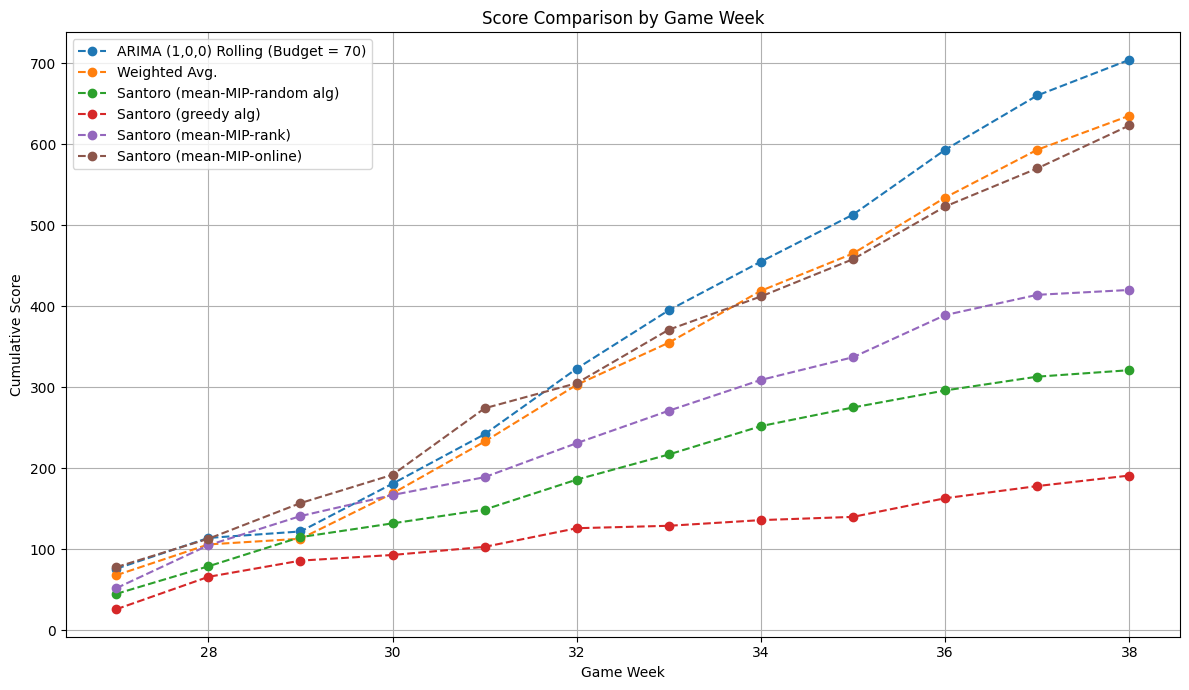

In [107]:
import matplotlib.pyplot as plt

Sdf = res

cols = [

"ARIMA (1,0,0) Rolling (Budget = 70)","Weighted Avg." , "Santoro (mean-MIP-random alg)",	"Santoro (greedy alg)"	,"Santoro (mean-MIP-rank)"	,"Santoro (mean-MIP-online)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Here are plots in the paper

Averaging methods and robust counterparts

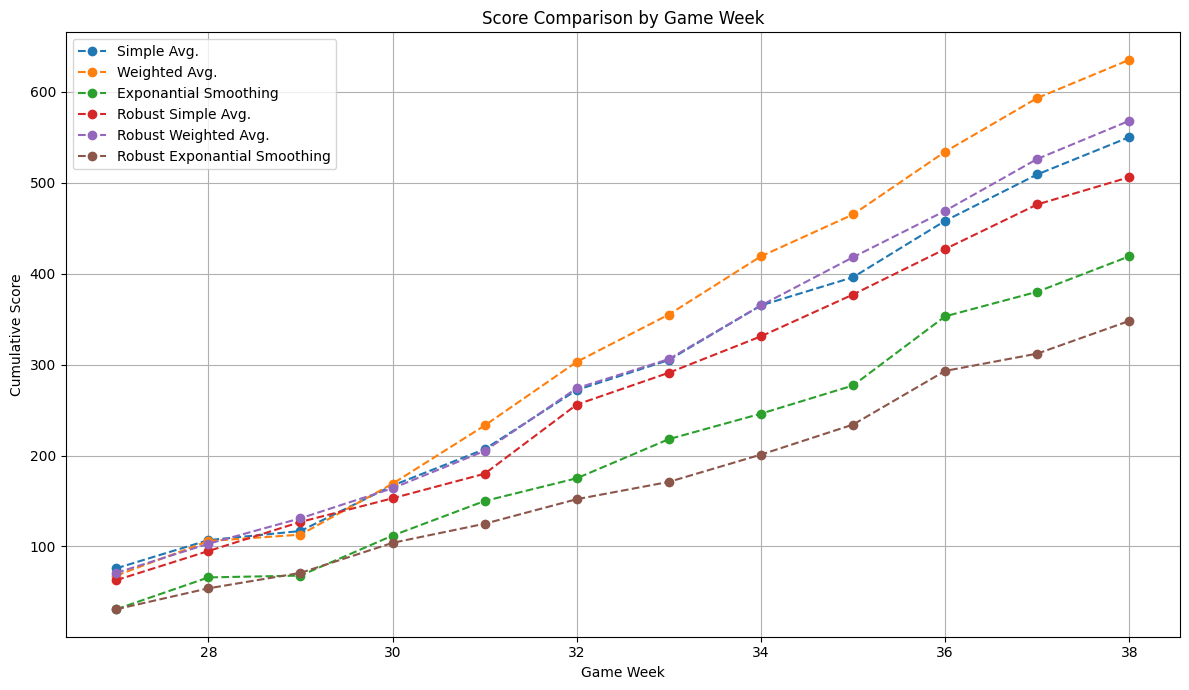

In [108]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
'Simple Avg.',"Weighted Avg.","Exponantial Smoothing",
"Robust Simple Avg.", "Robust Weighted Avg.",
         "Robust Exponantial Smoothing"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Simulation methods (bootstrap vs. Monte Carlo)

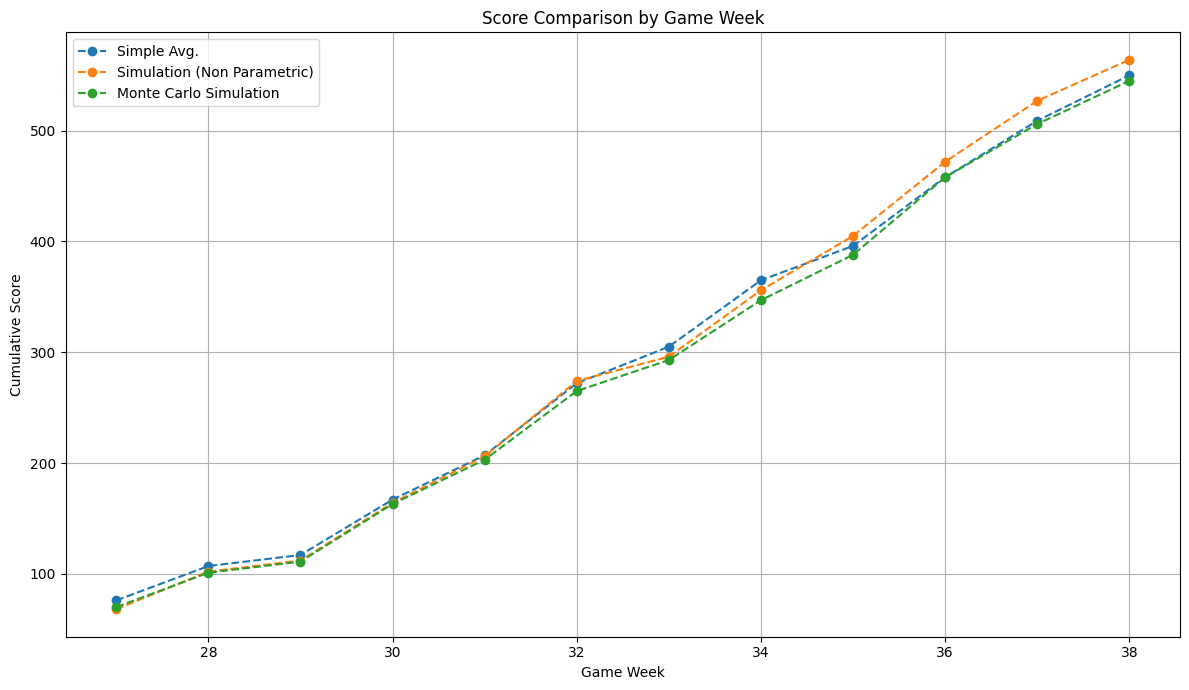

In [113]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
'Simple Avg.','Simulation (Non Parametric)','Monte Carlo Simulation'
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Out-of-sample performance of ARIMA variants. Simpler models
(ARIMA (0,0,1) and ARIMA (1,0,1)) outperform higher-order configurations.28 30 32 34 36 38

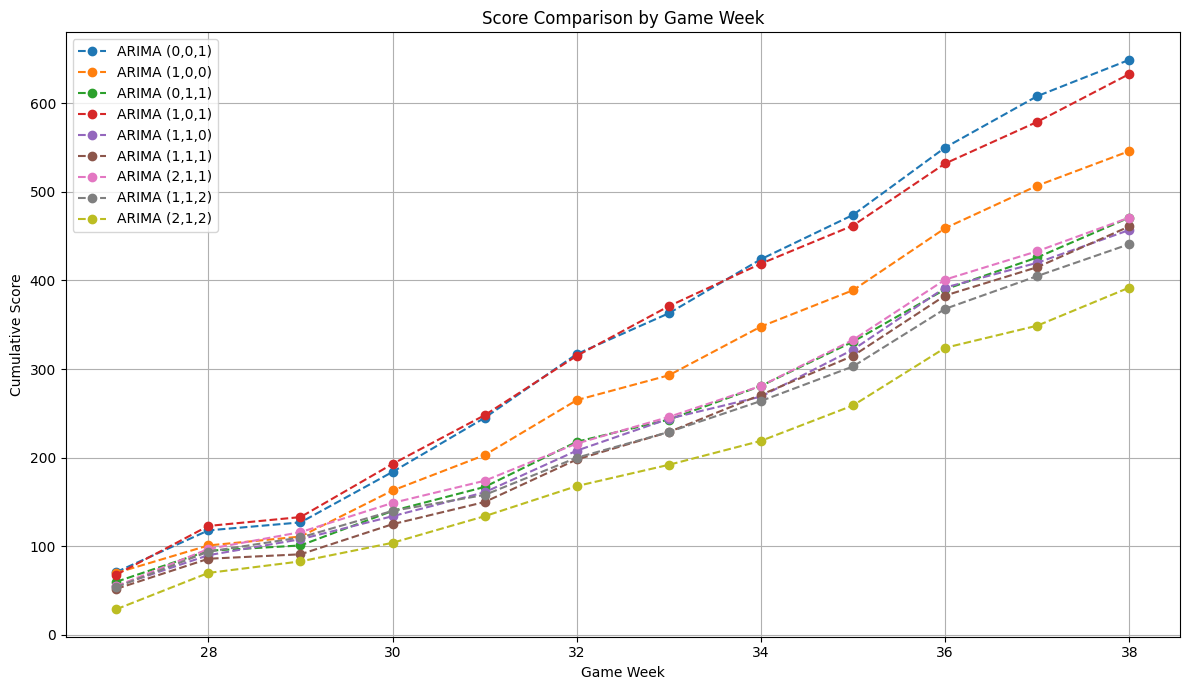

In [114]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
         "ARIMA (0,0,1)",
         "ARIMA (1,0,0)",
         "ARIMA (0,1,1)",
         "ARIMA (1,0,1)",
         "ARIMA (1,1,0)",
         "ARIMA (1,1,1)",
         "ARIMA (2,1,1)",
         "ARIMA (1,1,2)",
         "ARIMA (2,1,2)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Alternative objectives: ICT, robust ICT, and involvement (EGI-EGC).

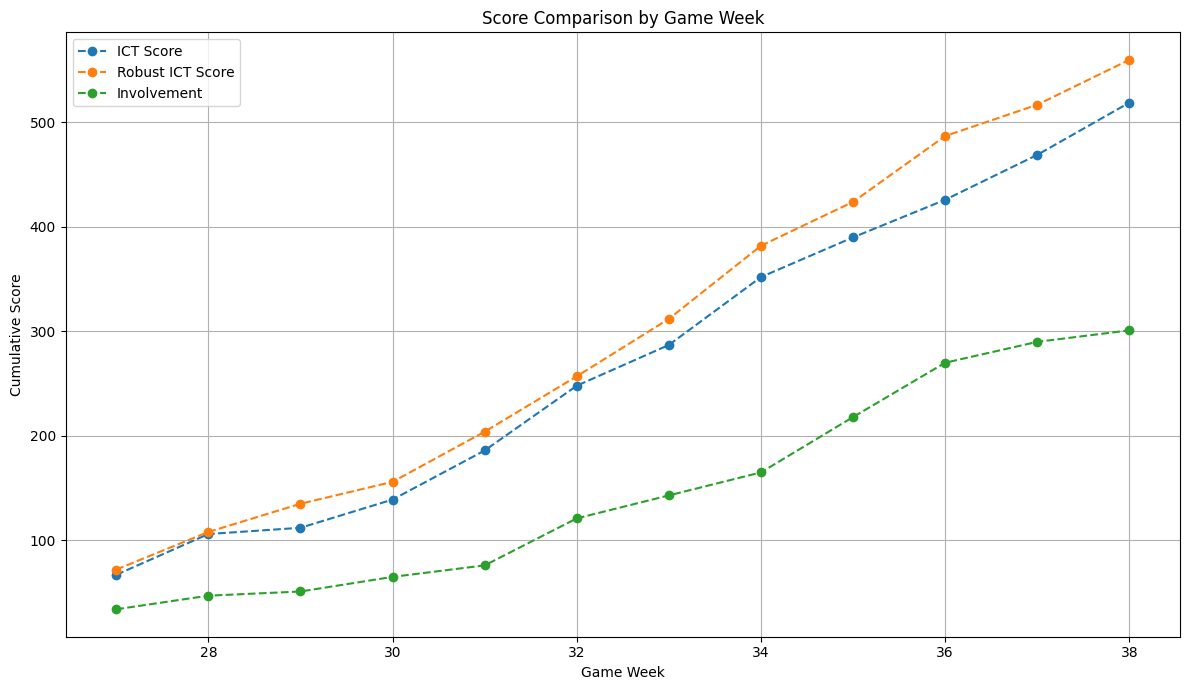

In [115]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ICT Score","Robust ICT Score","Involvement"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Hybrid over averaging methods

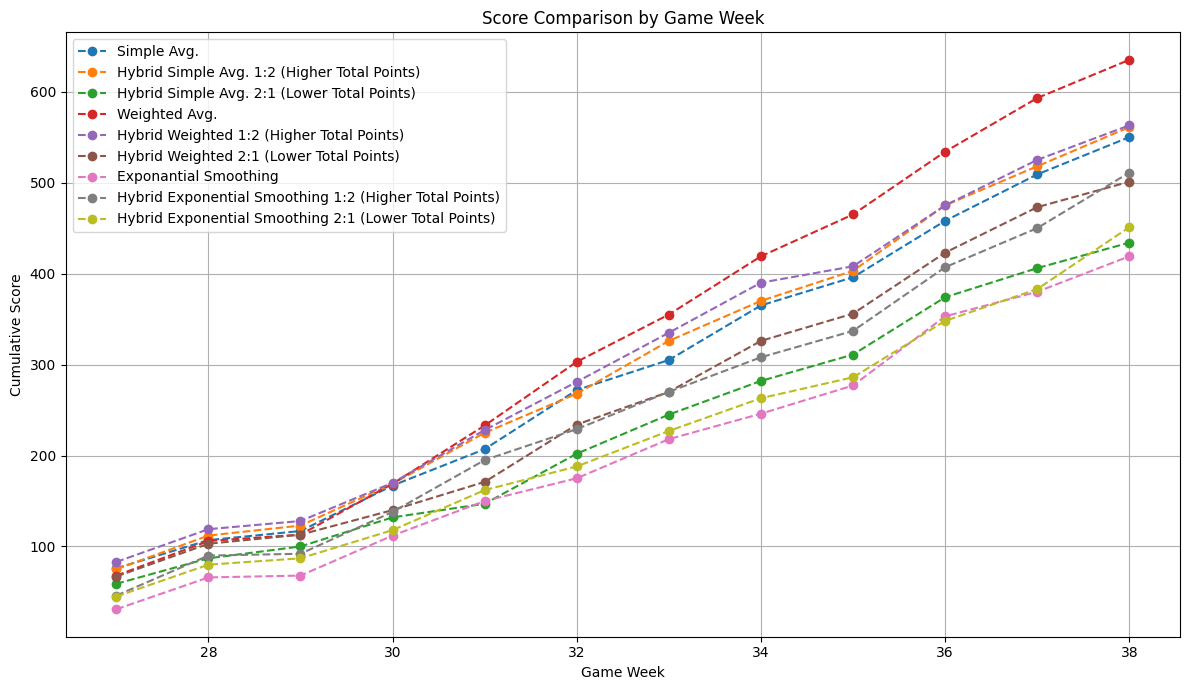

In [116]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Simple Avg.","Hybrid Simple Avg. 1:2 (Higher Total Points)",
         "Hybrid Simple Avg. 2:1 (Lower Total Points)",
         "Weighted Avg.","Hybrid Weighted 1:2 (Higher Total Points)",
         "Hybrid Weighted 2:1 (Lower Total Points)", "Exponantial Smoothing",
         "Hybrid Exponential Smoothing 1:2 (Higher Total Points)",
         "Hybrid Exponential Smoothing 2:1 (Lower Total Points)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Hybrid over simulation methods

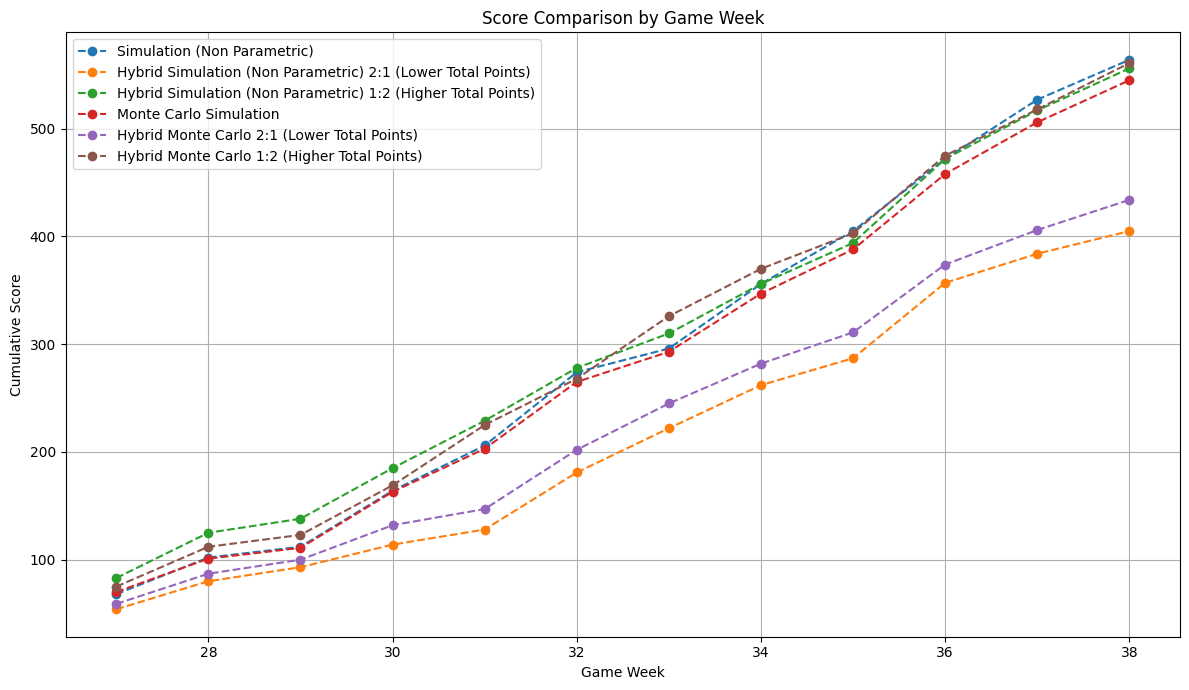

In [121]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Simulation (Non Parametric)",
        "Hybrid Simulation (Non Parametric) 2:1 (Lower Total Points)",
         "Hybrid Simulation (Non Parametric) 1:2 (Higher Total Points)",
          "Monte Carlo Simulation",
         "Hybrid Monte Carlo 2:1 (Lower Total Points)",
        "Hybrid Monte Carlo 1:2 (Higher Total Points)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Hybrid vs. ARIMA (0,0,1)

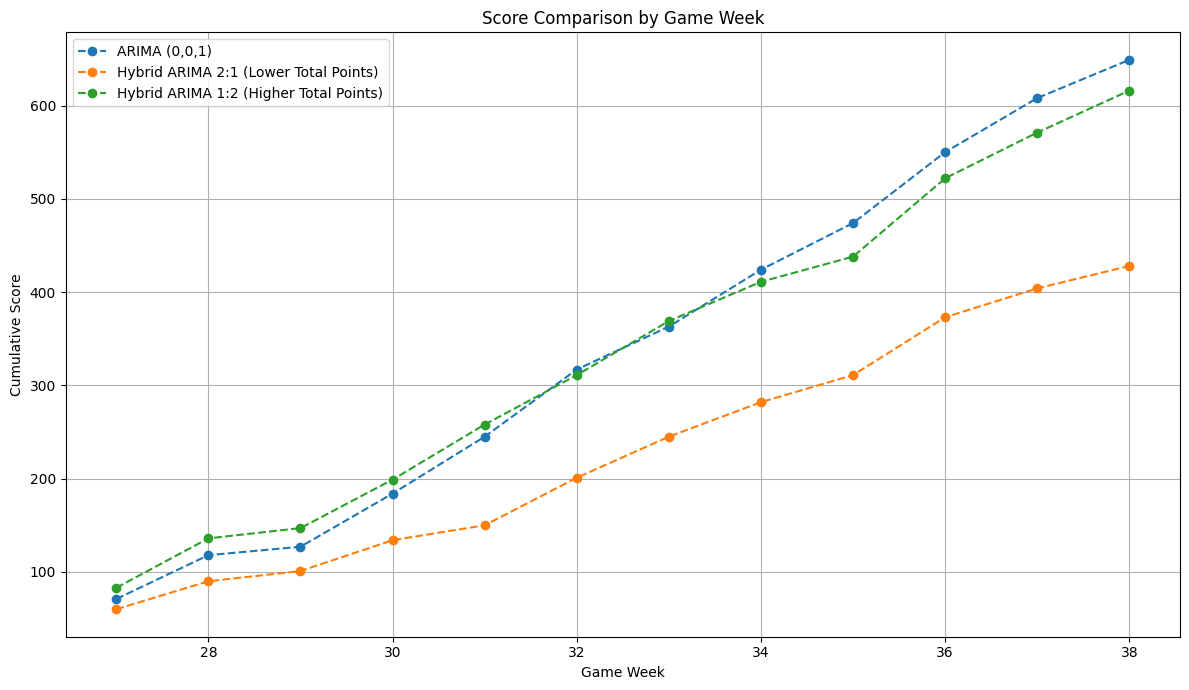

In [122]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (0,0,1)",
         "Hybrid ARIMA 2:1 (Lower Total Points)",
         "Hybrid ARIMA 1:2 (Higher Total Points)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Hybrid ICT vs. ICT and linear regression

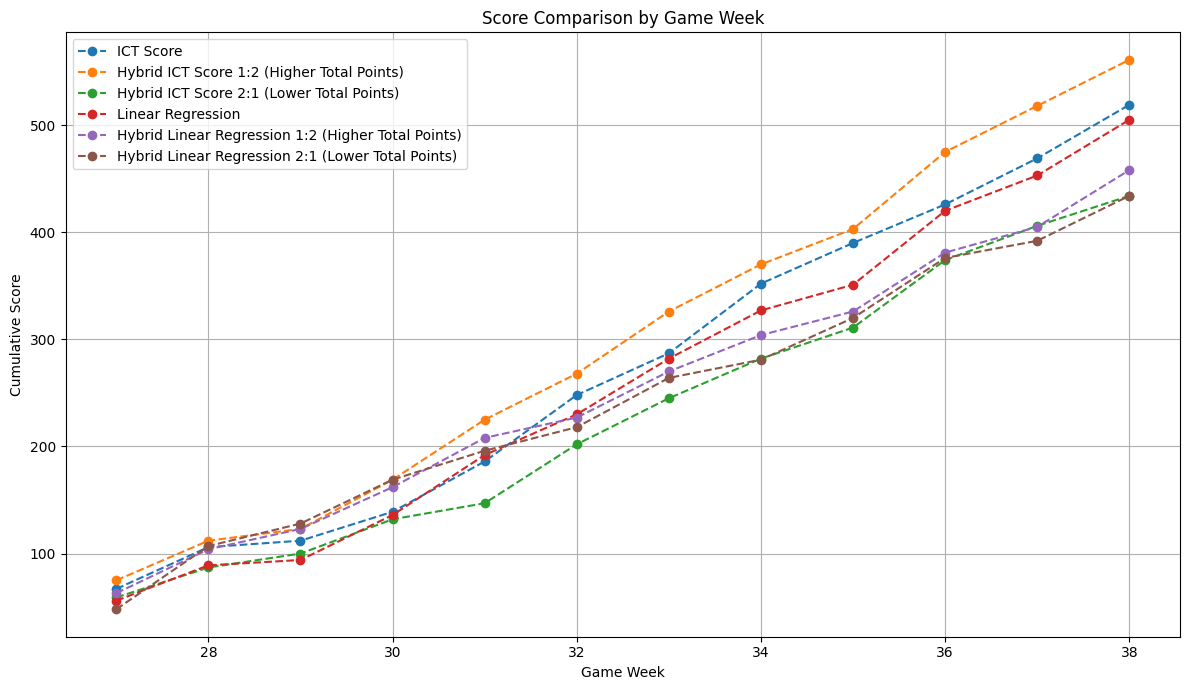

In [126]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ICT Score",
         "Hybrid ICT Score 1:2 (Higher Total Points)",
         "Hybrid ICT Score 2:1 (Lower Total Points)",
         "Linear Regression",
         "Hybrid Linear Regression 1:2 (Higher Total Points)",
         "Hybrid Linear Regression 2:1 (Lower Total Points)"

]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


#Budget Sensitivity

Simple average

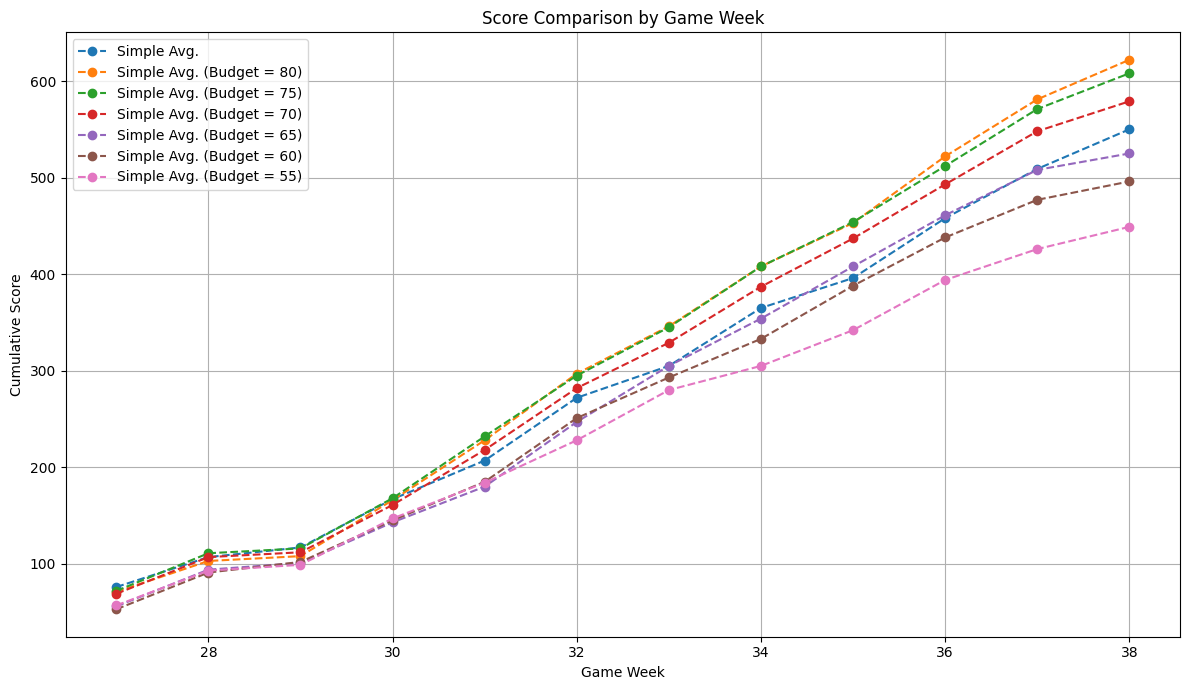

In [127]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
  "Simple Avg.",
  "Simple Avg. (Budget = 80)",
  "Simple Avg. (Budget = 75)",
  "Simple Avg. (Budget = 70)",
  "Simple Avg. (Budget = 65)",
  "Simple Avg. (Budget = 60)",
  "Simple Avg. (Budget = 55)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Weighted average

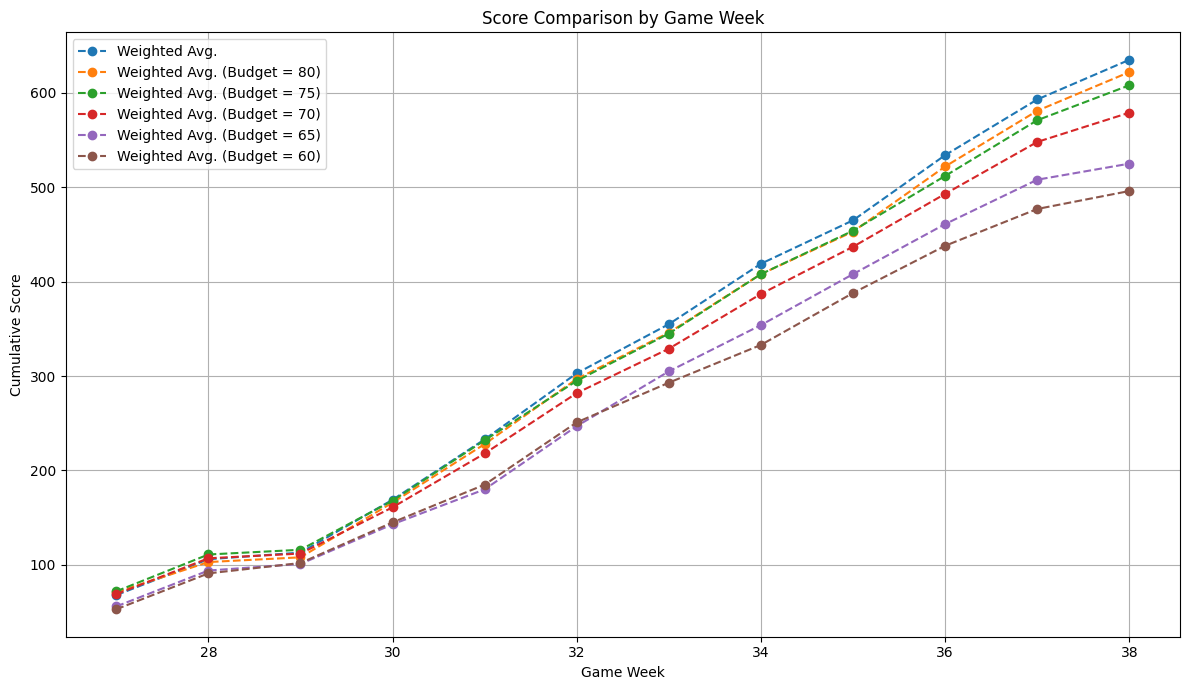

In [135]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Weighted Avg.",
"Weighted Avg. (Budget = 80)",
"Weighted Avg. (Budget = 75)",
"Weighted Avg. (Budget = 70)",
"Weighted Avg. (Budget = 65)",
"Weighted Avg. (Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


 ARIMA (0,0,1)

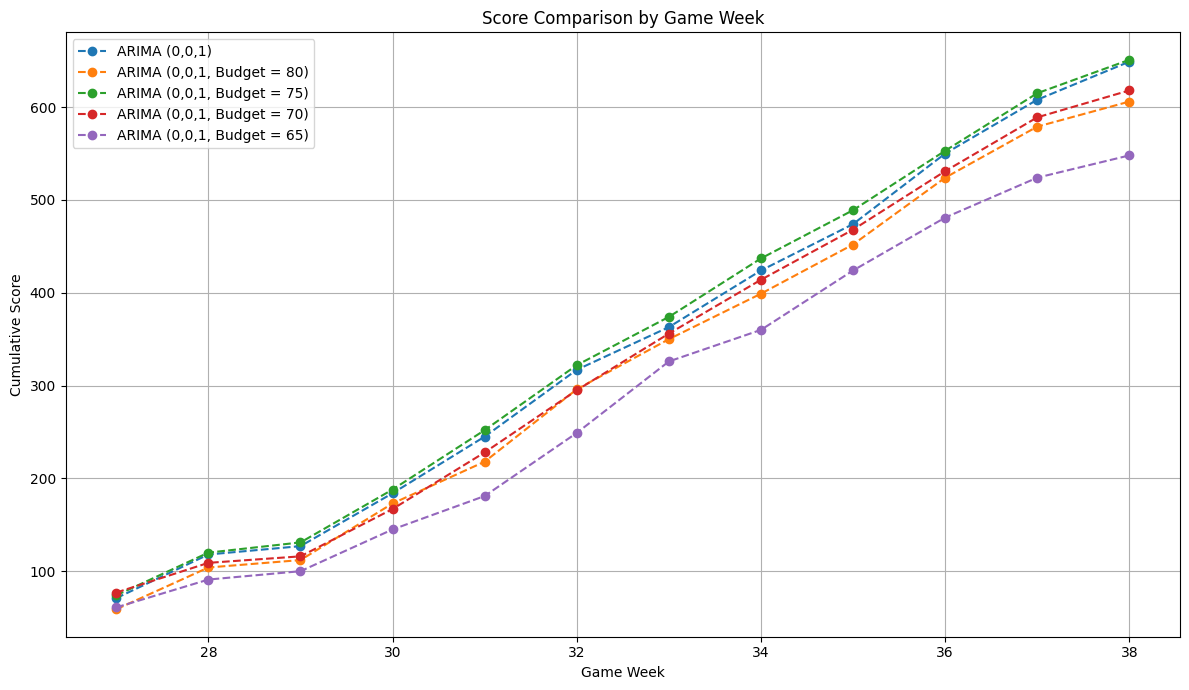

In [136]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (0,0,1)",
"ARIMA (0,0,1, Budget = 80)",
"ARIMA (0,0,1, Budget = 75)",
"ARIMA (0,0,1, Budget = 70)",
"ARIMA (0,0,1, Budget = 65)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


ARIMA (1,0,0)

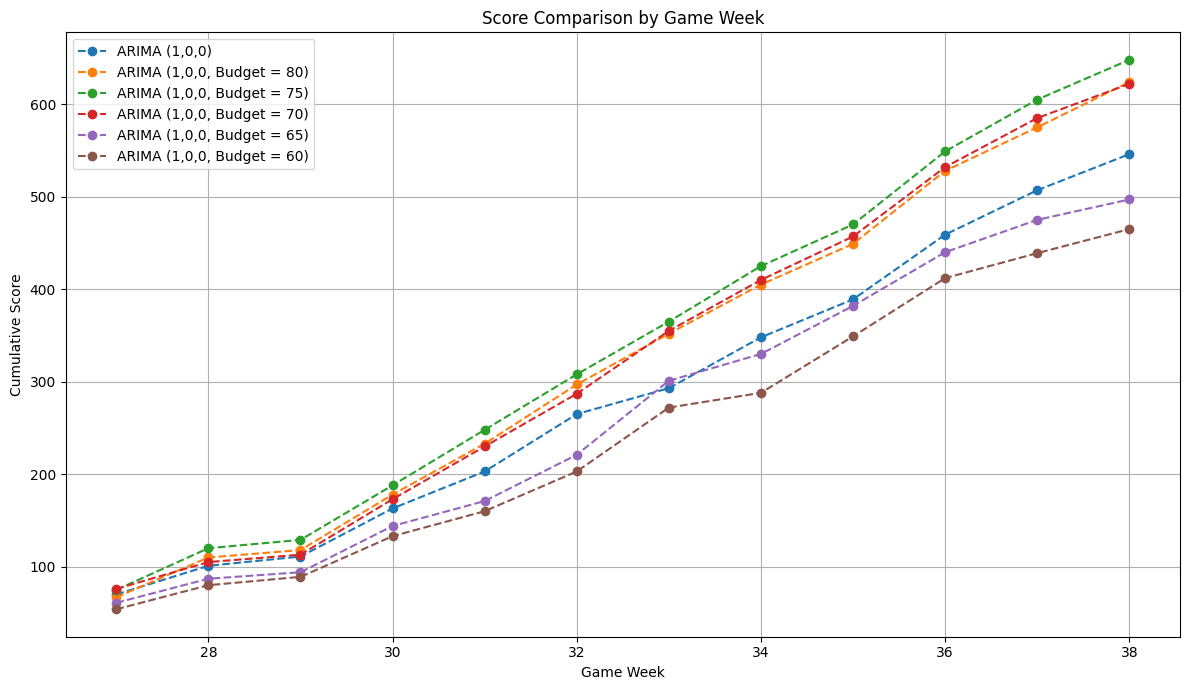

In [137]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (1,0,0)",
"ARIMA (1,0,0, Budget = 80)",
"ARIMA (1,0,0, Budget = 75)",
"ARIMA (1,0,0, Budget = 70)",
"ARIMA (1,0,0, Budget = 65)",
"ARIMA (1,0,0, Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


ARIMA (1,0,1)

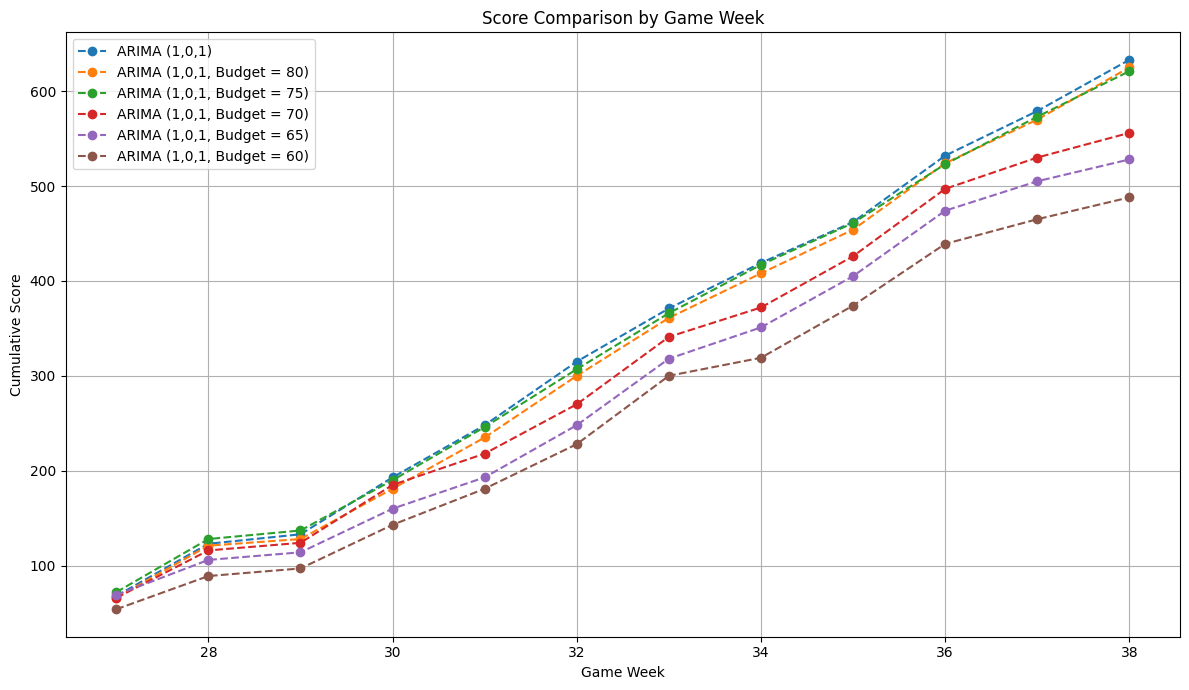

In [138]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (1,0,1)",
"ARIMA (1,0,1, Budget = 80)",
"ARIMA (1,0,1, Budget = 75)",
"ARIMA (1,0,1, Budget = 70)",
"ARIMA (1,0,1, Budget = 65)",
"ARIMA (1,0,1, Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


ICT

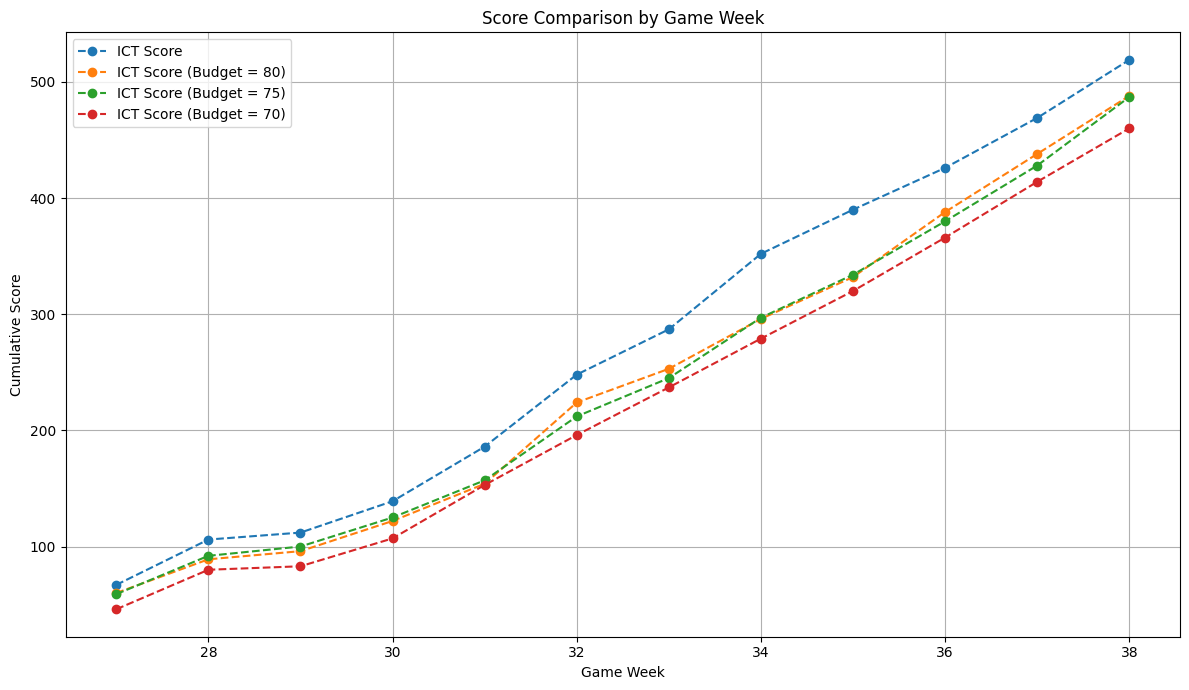

In [139]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ICT Score",
"ICT Score (Budget = 80)",
"ICT Score (Budget = 75)",
"ICT Score (Budget = 70)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Hybrid ICT (1:2)

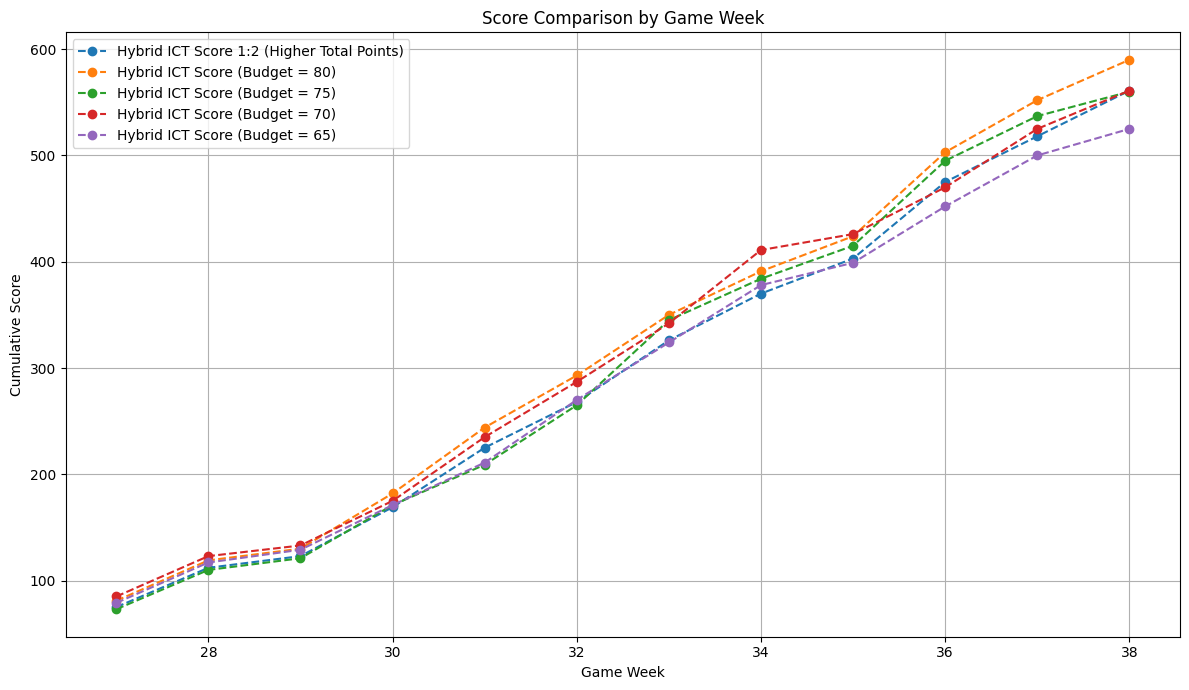

In [140]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Hybrid ICT Score 1:2 (Higher Total Points)",
"Hybrid ICT Score (Budget = 80)",
"Hybrid ICT Score (Budget = 75)",
"Hybrid ICT Score (Budget = 70)",
"Hybrid ICT Score (Budget = 65)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Monte Carlo

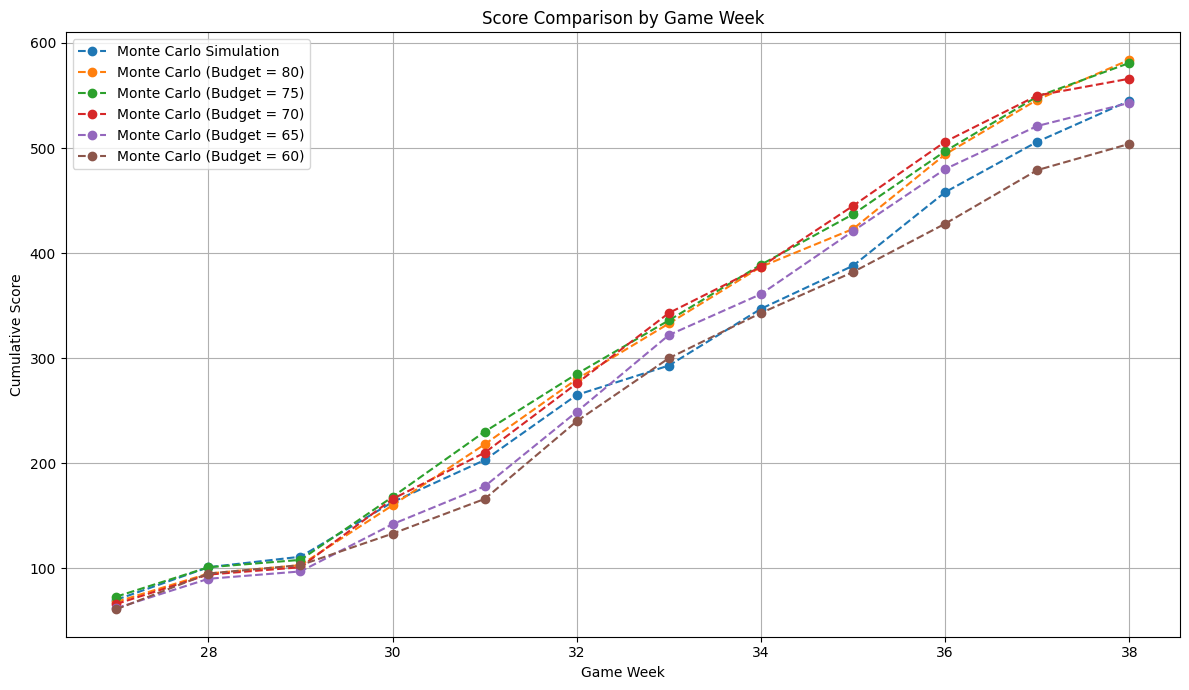

In [141]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Monte Carlo Simulation",
"Monte Carlo (Budget = 80)",
"Monte Carlo (Budget = 75)",
"Monte Carlo (Budget = 70)",
"Monte Carlo (Budget = 65)",
"Monte Carlo (Budget = 60)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


#Rolling Window + Budget Sensitivity

ARIMA (1,0,0) (rolling)

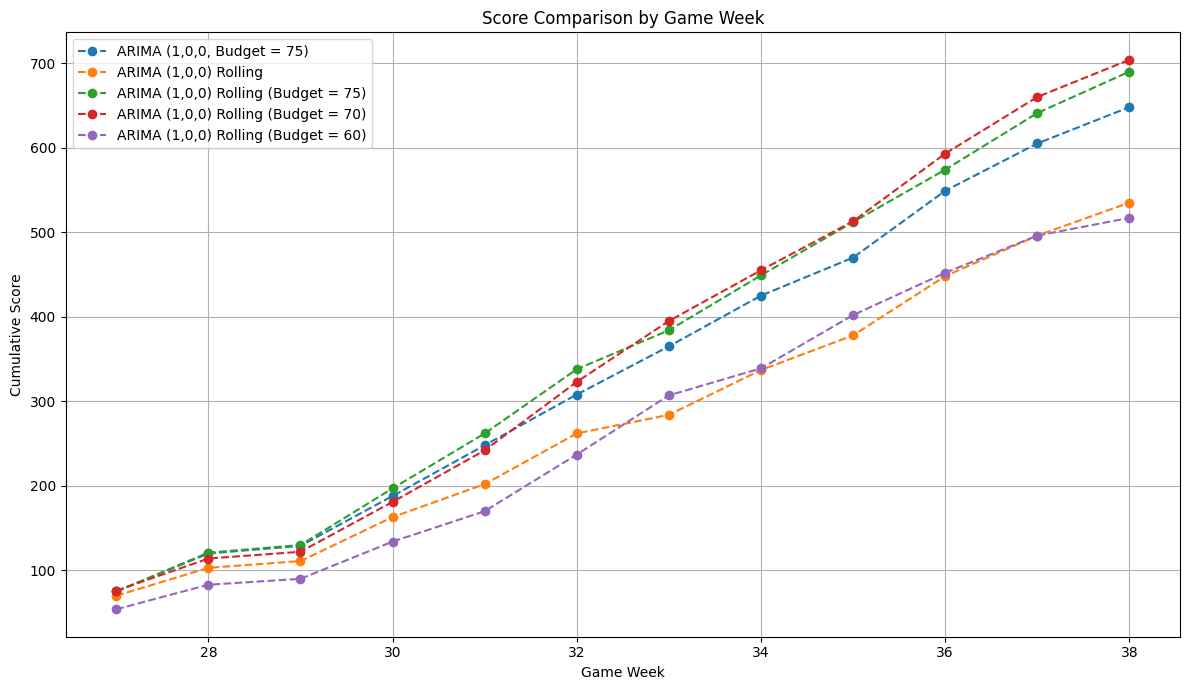

In [142]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (1,0,0, Budget = 75)",
        "ARIMA (1,0,0) Rolling",
         "ARIMA (1,0,0) Rolling (Budget = 75)",
         "ARIMA (1,0,0) Rolling (Budget = 70)",
         "ARIMA (1,0,0) Rolling (Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


ARIMA (1,0,1) (rolling)

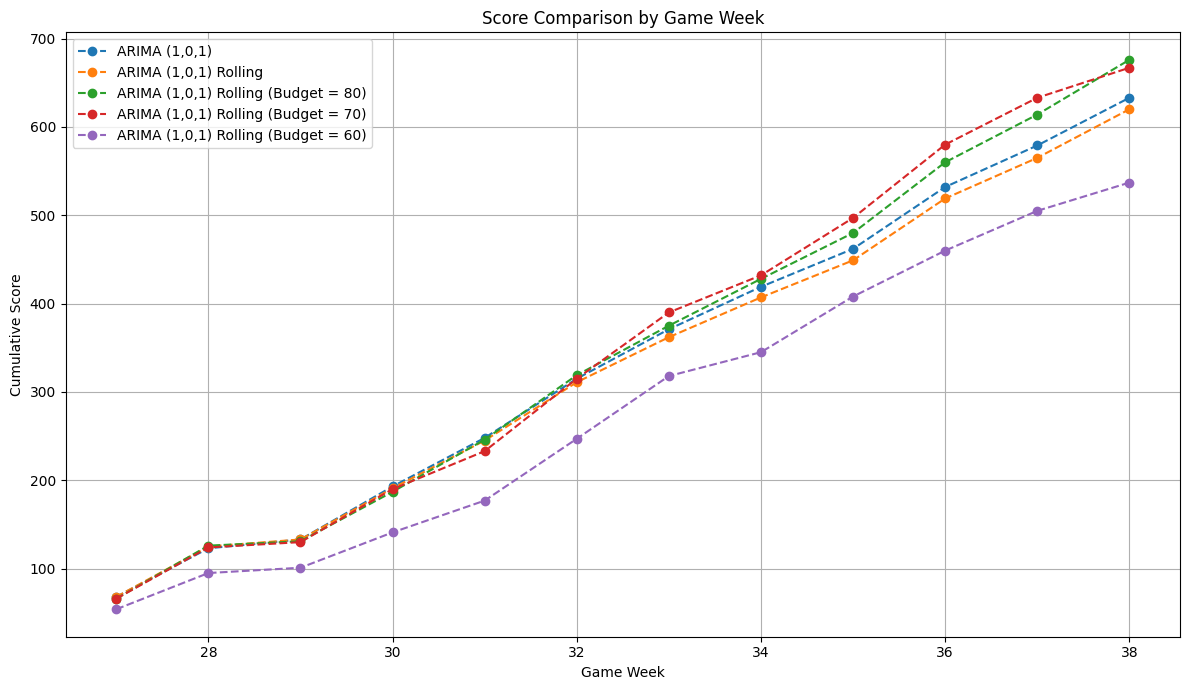

In [143]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
    "ARIMA (1,0,1)",
          "ARIMA (1,0,1) Rolling",
          "ARIMA (1,0,1) Rolling (Budget = 80)",
          "ARIMA (1,0,1) Rolling (Budget = 70)",
          "ARIMA (1,0,1) Rolling (Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Simple average (rolling)

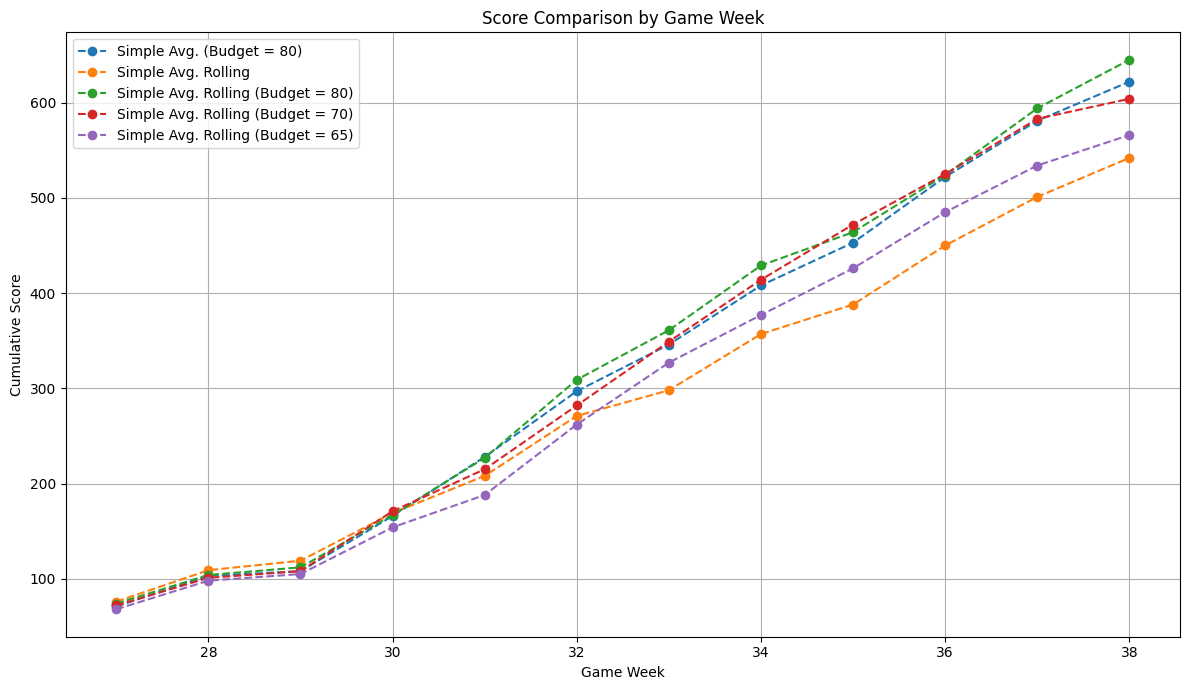

In [144]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
'Simple Avg. (Budget = 80)',
"Simple Avg. Rolling",
"Simple Avg. Rolling (Budget = 80)",
"Simple Avg. Rolling (Budget = 70)",
"Simple Avg. Rolling (Budget = 65)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


Weighted average (rolling)

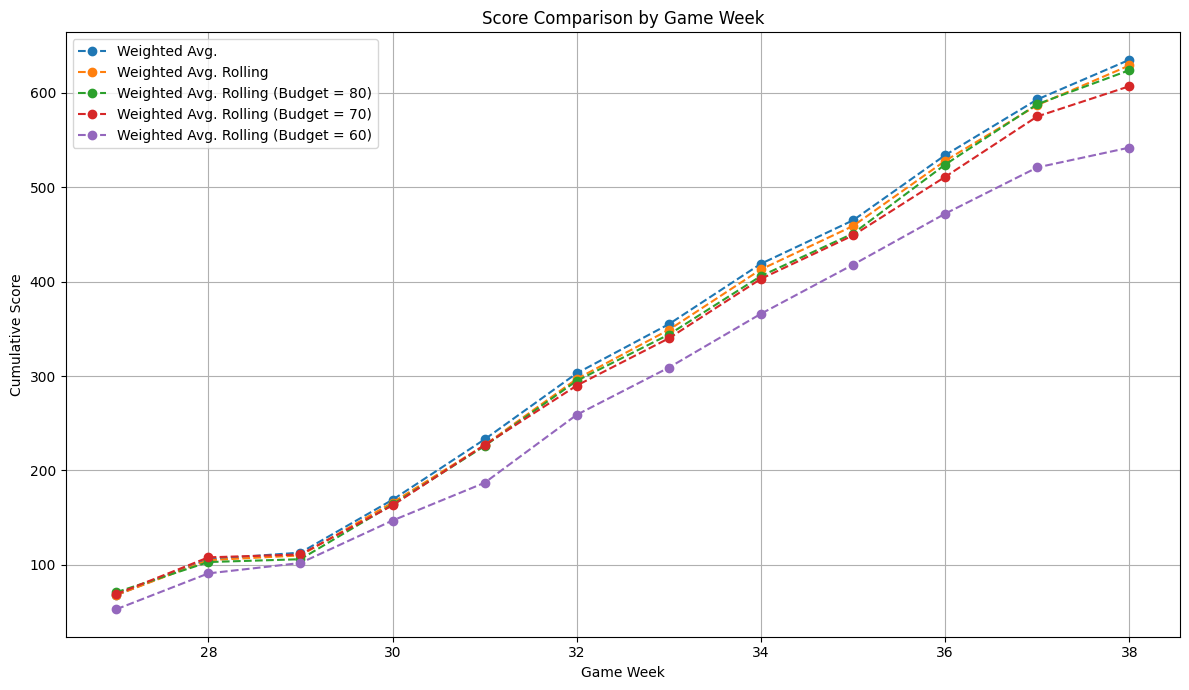

In [145]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"Weighted Avg.",
"Weighted Avg. Rolling",
"Weighted Avg. Rolling (Budget = 80)",
"Weighted Avg. Rolling (Budget = 70)",
"Weighted Avg. Rolling (Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


ARIMA (0,0,1) (rolling)

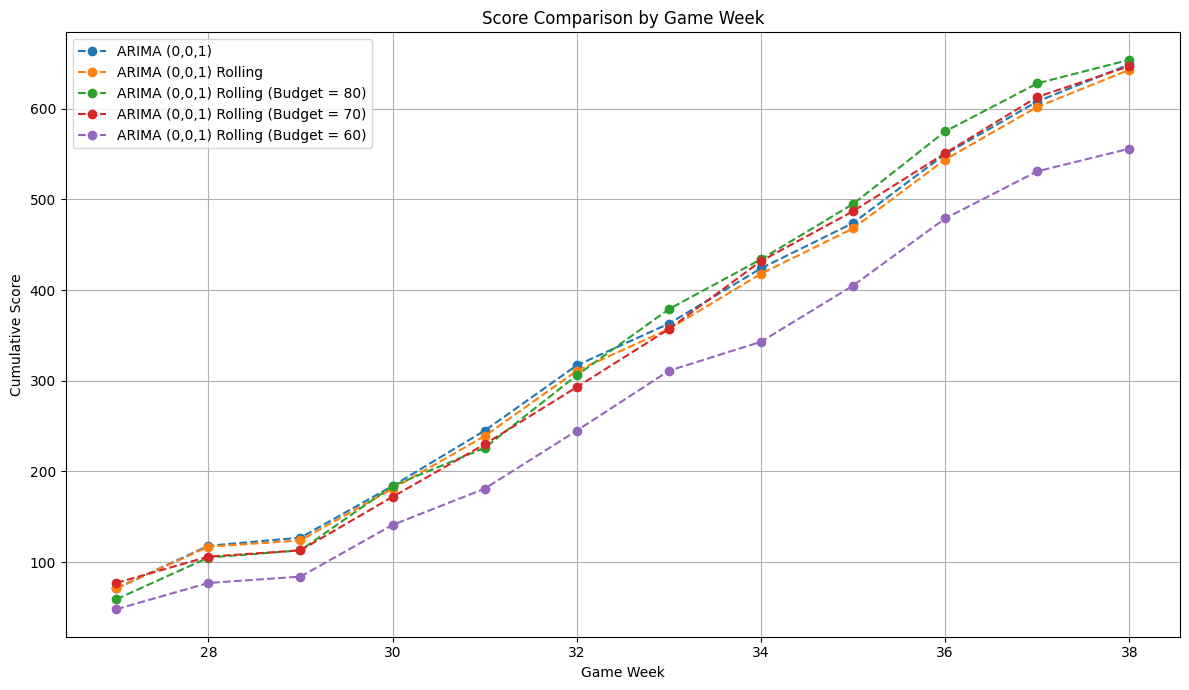

In [146]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (0,0,1)",
"ARIMA (0,0,1) Rolling",
"ARIMA (0,0,1) Rolling (Budget = 80)",
"ARIMA (0,0,1) Rolling (Budget = 70)",
"ARIMA (0,0,1) Rolling (Budget = 60)",
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


#Best-performing models across families (cumulative points)

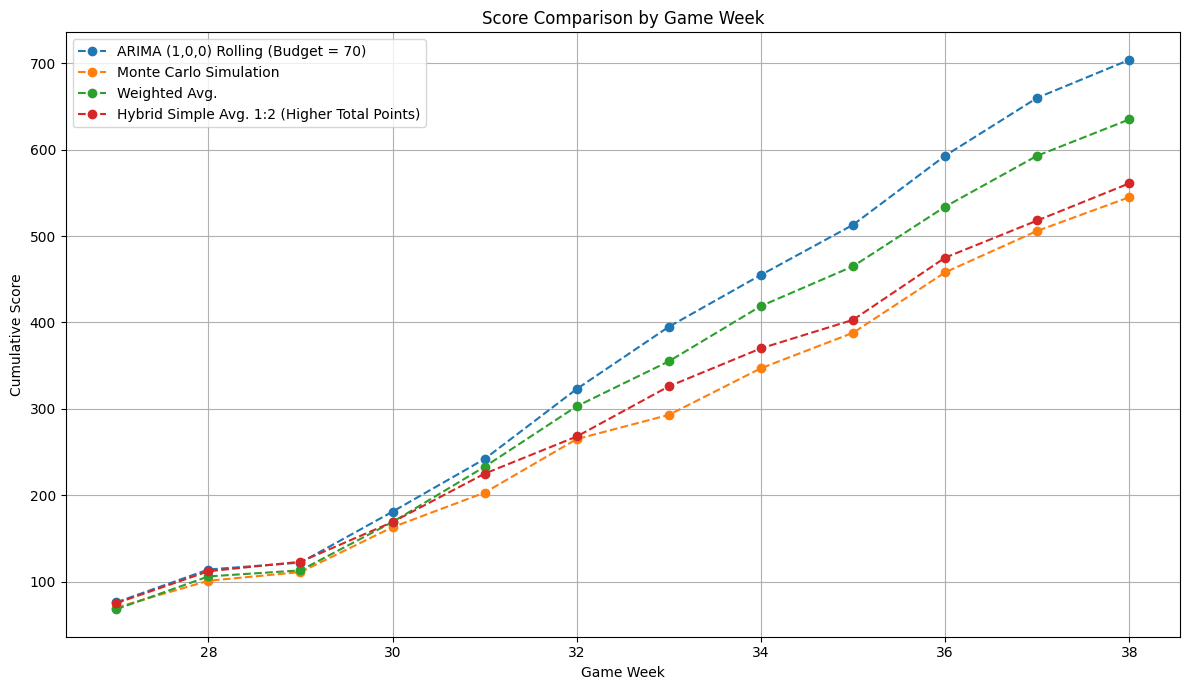

In [147]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
"ARIMA (1,0,0) Rolling (Budget = 70)",
"Monte Carlo Simulation",
"Weighted Avg.",
"Hybrid Simple Avg. 1:2 (Higher Total Points)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Plot with dots instead of continuous lines
plt.figure(figsize=(12, 7))

for col in cumulative.columns:
    plt.plot(gameweeks, cumulative[col], marker="o", linestyle="--", label=col)

plt.xlabel("Game Week")
plt.ylabel("Cumulative Score")
plt.title("Score Comparison by Game Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("img.pdf", format="pdf")
plt.show()


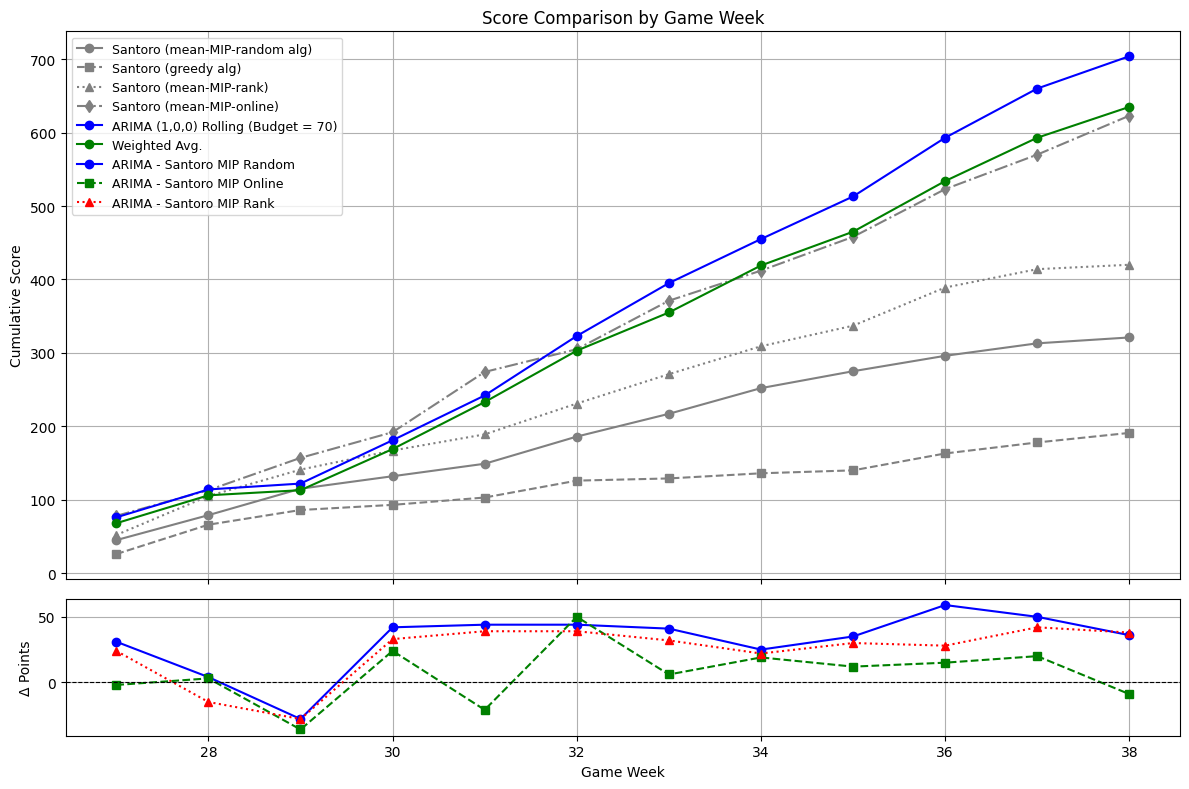

In [148]:
import matplotlib.pyplot as plt

Sdf = res

cols = [
    "ARIMA (1,0,0) Rolling (Budget = 70)",
    "Weighted Avg.",
    "Santoro (mean-MIP-random alg)",
    "Santoro (greedy alg)",
    "Santoro (mean-MIP-rank)",
    "Santoro (mean-MIP-online)"
]

# Compute cumulative sums
cumulative = Sdf[cols].cumsum()

# Define game weeks explicitly
gameweeks = list(range(27, 27 + len(Sdf)))

# Create figure with two panels (main + slim difference panel)
fig, (ax_main, ax_diff) = plt.subplots(
    2, 1, figsize=(12, 8),
    gridspec_kw={"height_ratios": [4, 1]},
    sharex=True
)

# Define line styles and markers for Santoro benchmarks
benchmark_styles = {
    "Santoro (mean-MIP-random alg)": ("-", "o"),
    "Santoro (greedy alg)": ("--", "s"),
    "Santoro (mean-MIP-rank)": (":", "^"),
    "Santoro (mean-MIP-online)": ("-.", "d")
}

# Plot Santoro benchmarks in gray with different styles
for col, (linestyle, marker) in benchmark_styles.items():
    ax_main.plot(gameweeks, cumulative[col], linestyle=linestyle, marker=marker, color="gray", label=col)

# Overlay ARIMA and Weighted Avg.
line_arima, = ax_main.plot(gameweeks, cumulative["ARIMA (1,0,0) Rolling (Budget = 70)"], marker="o", linestyle="-", color="blue", label="ARIMA (1,0,0) Rolling (Budget = 70)")
line_weighted, = ax_main.plot(gameweeks, cumulative["Weighted Avg."], marker="o", linestyle="-", color="green", label="Weighted Avg.")

ax_main.set_ylabel("Cumulative Score")
ax_main.set_title("Score Comparison by Game Week")
ax_main.grid(True)

# Slim panel: per-GW differences
arima_diff = Sdf["ARIMA (1,0,0) Rolling (Budget = 70)"] - Sdf["Santoro (mean-MIP-random alg)"]
arima_diff2 = Sdf["ARIMA (1,0,0) Rolling (Budget = 70)"] - Sdf["Santoro (mean-MIP-online)"]
arima_diff3 = Sdf["ARIMA (1,0,0) Rolling (Budget = 70)"] - Sdf["Santoro (mean-MIP-rank)"]

line_diff1, = ax_diff.plot(gameweeks, arima_diff, marker="o", linestyle="-", color="blue", label="ARIMA - Santoro MIP Random")
line_diff2, = ax_diff.plot(gameweeks, arima_diff2, marker="s", linestyle="--", color="green", label="ARIMA - Santoro MIP Online")
line_diff3, = ax_diff.plot(gameweeks, arima_diff3, marker="^", linestyle=":", color="red", label="ARIMA - Santoro MIP Rank")

ax_diff.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax_diff.set_xlabel("Game Week")
ax_diff.set_ylabel("Δ Points")
ax_diff.grid(True)

# Merge legends
lines = list(ax_main.get_lines()) + [line_diff1, line_diff2, line_diff3]
labels = [line.get_label() for line in lines]
ax_main.legend(lines, labels, loc="upper left", fontsize=9)

plt.tight_layout()
plt.savefig("img.pdf", format="pdf")
plt.show()


Processing position: GK
Hybrid RMSE for position GK: 1.3033


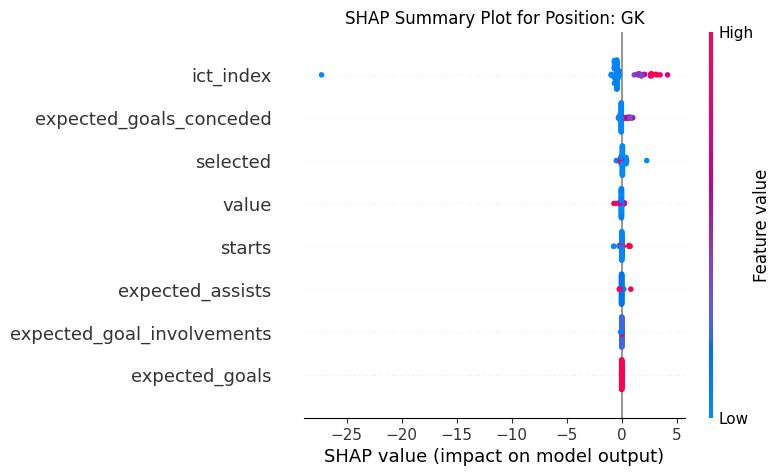

Processing position: DEF
Hybrid RMSE for position DEF: 2.7945


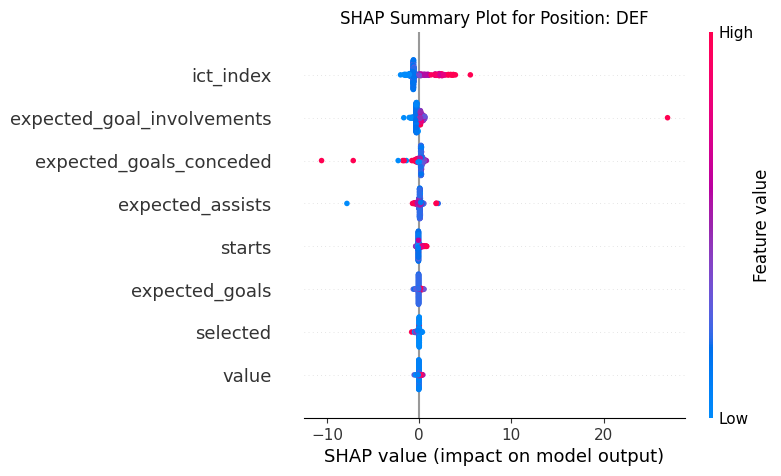

Processing position: MID
Hybrid RMSE for position MID: 1.1425


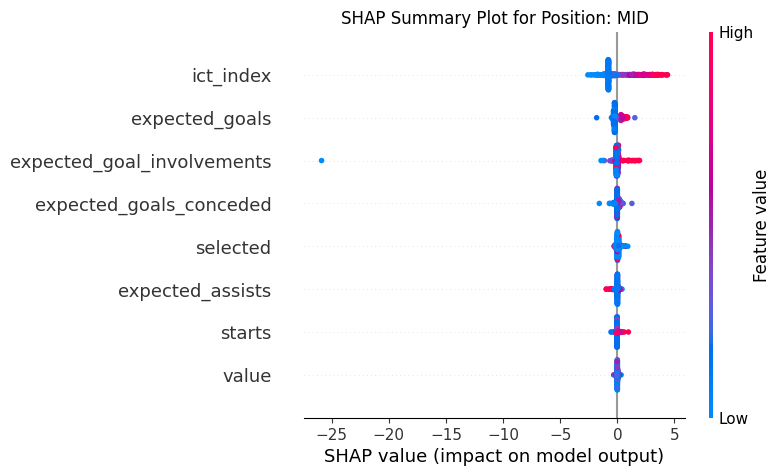

Processing position: FWD
Hybrid RMSE for position FWD: 0.5264


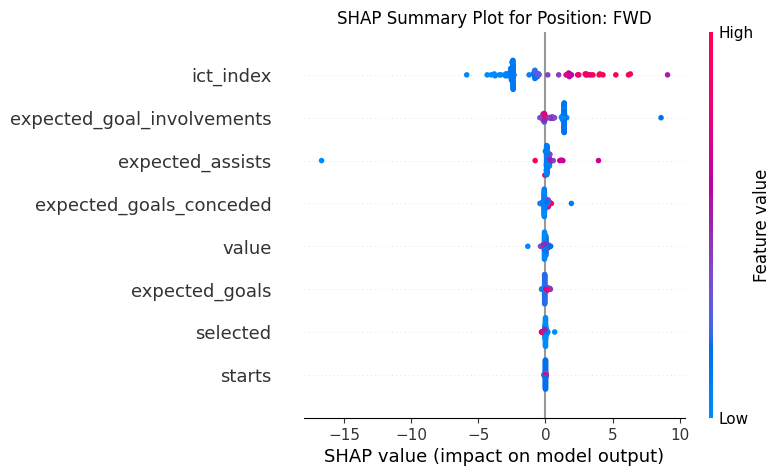

name           team position  expected points  \
0             Femi Seriki  Sheffield Utd      DEF         0.000000   
1        Jack Hinshelwood       Brighton      MID         2.170940   
2            Jadon Sancho        Man Utd      MID         0.017094   
3  Rhys Norrington-Davies  Sheffield Utd      DEF         0.119658   
4           Vitaly Janelt      Brentford      MID         2.296296   

   uncertainty  value  hybrid_points  
0     0.000000    3.9       1.748969  
1     2.815343    4.5       4.755517  
2     0.325813    6.7       0.273970  
3     0.392232    3.9       2.020768  
4     1.198075    5.3       2.725601

In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming scores_df is already loaded

# List of positions
positions = ['GK', 'DEF', 'MID', 'FWD']

# Create a new hybrid_points column
scores_df_['hybrid_points'] = 0.0

# Loop through each position
for position in positions:
    print(f"Processing position: {position}")

    # Filter data for the current position
    df_position = scores_df_[scores_df_['position'] == position].copy()

    if df_position.empty:
        print(f"No data for position: {position}. Skipping...")
        continue

    # Select relevant features
    feature_columns = [
        'value',
        'expected_assists',
        'expected_goal_involvements',
        'expected_goals',
        'expected_goals_conceded',
        'ict_index',
        'selected',
        'starts'
    ]

    X = df_position[feature_columns]
    y = df_position['total_points']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    # SHAP explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_scaled)

    # Get top 4 SHAP contributors for each sample
    shap_abs = np.abs(shap_values)
    top4_indices = np.argsort(-shap_abs, axis=1)[:, :4]  # Indices of top 4 features for each sample

    # Now, sum the actual feature values (not SHAP values) for the top 4 features
    X_array = X.to_numpy()
    top4_feature_sums = np.array([
        X_array[i, top4_indices[i]].sum() for i in range(X_array.shape[0])
    ])

    # Normalize top4_feature_sums for fair combination
    top4_feature_sums_norm = (top4_feature_sums - top4_feature_sums.min()) / (top4_feature_sums.max() - top4_feature_sums.min())

    # Combine total_points and top4 sum
    hybrid_points = y + top4_feature_sums_norm * y.max()  # Scale normalized sum to same magnitude

    # Map back to the main dataframe
    scores_df.loc[df_position.index, 'hybrid_points'] = hybrid_points

    # Optional: Evaluate model performance (still based on original split)
    X_train, X_test, y_train, y_test = train_test_split(X, hybrid_points, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Hybrid RMSE for position {position}: {rmse:.4f}')

    # Plot SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, feature_names=feature_columns, show=False)
    plt.title(f'SHAP Summary Plot for Position: {position}')
    plt.savefig(f"{position}.pdf", format="pdf")
    plt.show()

# Final check
scores_df.head()


In [151]:
print('The End')
from datetime import date

# Get today's date
today = date.today()

print("Today's date is:", today)


The End
Today's date is: 2025-10-09
